In [1]:
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.5f' % x)
import numpy as np
from sklearn.cluster import KMeans
from datetime import timedelta
from tqdm import tqdm


import matplotlib.pyplot as plt

%matplotlib inline
from importlib import reload
plt=reload(plt)
import seaborn as sns
sns.set()

import folium
from geopy.exc import GeocoderTimedOut
from geopy.geocoders import Nominatim

import warnings
warnings.filterwarnings("ignore")

# Data Cleaning

In [2]:
retail_df = pd.read_excel('online_retail_datesets.xlsx')

In [3]:
retail_df.shape

(525169, 8)

In [4]:
retail_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525169 entries, 0 to 525168
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      525169 non-null  object        
 1   StockCode    525169 non-null  object        
 2   Description  522241 non-null  object        
 3   Quantity     525169 non-null  int64         
 4   InvoiceDate  525169 non-null  datetime64[ns]
 5   Price        525169 non-null  float64       
 6   Customer ID  417242 non-null  float64       
 7   Country      525169 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 32.1+ MB


In [5]:
retail_df.describe(include = 'all')

Invoice StockCode                         Description  \
count  525169.00000    525169                              522241   
unique  28802.00000      4632                                4681   
top    537434.00000    85123A  WHITE HANGING HEART T-LIGHT HOLDER   
freq      675.00000      3516                                3549   
first           NaN       NaN                                 NaN   
last            NaN       NaN                                 NaN   
mean            NaN       NaN                                 NaN   
std             NaN       NaN                                 NaN   
min             NaN       NaN                                 NaN   
25%             NaN       NaN                                 NaN   
50%             NaN       NaN                                 NaN   
75%             NaN       NaN                                 NaN   
max             NaN       NaN                                 NaN   

           Quantity          InvoiceDate        Price  Customer ID  \
count  525169.00000               525169 525169.00000 417242.00000   
unique          NaN                25285          NaN          NaN   
top             NaN  2010-12-06 16:57:00          NaN          NaN   
freq            NaN                  675          NaN          NaN   
first           NaN  2009-12-01 07:45:00          NaN          NaN   
last            NaN  2010-12-09 20:01:00          NaN          NaN   
mean       10.34342                  NaN      4.69016  15360.70750   
std       107.45178                  NaN    146.16751   1681.10175   
min     -9600.00000                  NaN -53594.36000  12346.00000   
25%         1.00000                  NaN      1.25000  13983.00000   
50%         3.00000                  NaN      2.10000  15311.00000   
75%        10.00000                  NaN      4.21000  16799.00000   
max     19152.00000                  NaN  25111.09000  18287.00000   

               Country  
count           525169  
unique              40  
top     United Kingdom  
freq            485560  
first              NaN  
last               NaN  
mean               NaN  
std                NaN  
min                NaN  
25%                NaN  
50%                NaN  
75%                NaN  
max                NaN

 - Through the two last two code cells above, I can infer that the 'Customer ID' and 'Description' columns have NaN values. 
 <br>Also, there are negative values in Quantity, which can be because of refunds.

## Dropping Duplicate Rows

In [6]:
print(f'The shape of the dataset before dropping duplicate {retail_df.shape} ')

The shape of the dataset before dropping duplicate (525169, 8) 


In [7]:
retail_df = retail_df.drop_duplicates()

In [8]:
print(f'The shape of the dataset after dropping duplicate. {retail_df.shape} ')

The shape of the dataset after dropping duplicate. (518304, 8) 


### Checking for Missing Values

In [9]:
round((retail_df.isnull().sum() / 525169) * 100, 2)

Invoice        0.00000
StockCode      0.00000
Description    0.56000
Quantity       0.00000
InvoiceDate    0.00000
Price          0.00000
Customer ID   20.53000
Country        0.00000
dtype: float64

- For some reason, 20% of values in the 'Customer ID' column are NaN. 
- As this dataset is from the Kaggle, I will not be able to ask for a better dataset nor to ask the reason why it contains NaN values.
- Before taking any actions, it would be better to examine rows that contain NaN values.



#### 'Customer ID' Column

In [10]:
retail_df[retail_df['Customer ID'].isna()].head(20)

Invoice StockCode                       Description  Quantity  \
263   489464     21733                      85123a mixed       -96   
283   489463     71477                             short      -240   
284   489467    85123A                       21733 mixed      -192   
470   489521     21646                               NaN       -50   
577   489525    85226C         BLUE PULL BACK RACING CAR         1   
578   489525     85227       SET/6 3D KIT CARDS FOR KIDS         1   
1055  489548     22271              FELTCRAFT DOLL ROSIE         1   
1056  489548     22254              FELT TOADSTOOL LARGE        12   
1057  489548     22273              FELTCRAFT DOLL MOLLY         3   
1058  489548     22195      LARGE HEART MEASURING SPOONS         1   
1059  489548     22131  FOOD CONTAINER SET 3 LOVE HEART          2   
1060  489548     22079        RIBBON REEL HEARTS DESIGN         10   
1061  489548     22138     BAKING SET 9 PIECE RETROSPOT          3   
1062  489548     22147        FELTCRAFT BUTTERFLY HEARTS         2   
1063  489548     22142      CHRISTMAS CRAFT WHITE FAIRY          2   
1064  489548     22150          3 STRIPEY MICE FELTCRAFT         2   
1065  489548     20804         GLASS CHICKEN BUTTER DISH         1   
1066  489548     22196      SMALL HEART MEASURING SPOONS         8   
1067  489548     22086   PAPER CHAIN KIT 50'S CHRISTMAS          3   
1068  489548     21115             ROSE CARAVAN DOORSTOP         1   

             InvoiceDate   Price  Customer ID         Country  
263  2009-12-01 10:52:00 0.00000          NaN  United Kingdom  
283  2009-12-01 10:52:00 0.00000          NaN  United Kingdom  
284  2009-12-01 10:53:00 0.00000          NaN  United Kingdom  
470  2009-12-01 11:44:00 0.00000          NaN  United Kingdom  
577  2009-12-01 11:49:00 0.55000          NaN  United Kingdom  
578  2009-12-01 11:49:00 0.85000          NaN  United Kingdom  
1055 2009-12-01 12:32:00 2.95000          NaN  United Kingdom  
1056 2009-12-01 12:32:00 1.25000          NaN  United Kingdom  
1057 2009-12-01 12:32:00 2.95000          NaN  United Kingdom  
1058 2009-12-01 12:32:00 1.65000          NaN  United Kingdom  
1059 2009-12-01 12:32:00 1.95000          NaN  United Kingdom  
1060 2009-12-01 12:32:00 1.65000          NaN  United Kingdom  
1061 2009-12-01 12:32:00 4.95000          NaN  United Kingdom  
1062 2009-12-01 12:32:00 1.45000          NaN  United Kingdom  
1063 2009-12-01 12:32:00 1.45000          NaN  United Kingdom  
1064 2009-12-01 12:32:00 1.95000          NaN  United Kingdom  
1065 2009-12-01 12:32:00 1.65000          NaN  United Kingdom  
1066 2009-12-01 12:32:00 0.85000          NaN  United Kingdom  
1067 2009-12-01 12:32:00 2.95000          NaN  United Kingdom  
1068 2009-12-01 12:32:00 6.75000          NaN  United Kingdom

In [11]:
retail_df[retail_df['Customer ID'].isna()].tail(20)

Invoice StockCode                          Description  Quantity  \
524841  538154     21935                   SUKI  SHOULDER BAG         1   
524842  538154     22186                 RED STAR CARD HOLDER         1   
524843  538154     22187     GREEN CHRISTMAS TREE CARD HOLDER         1   
524844  538154     22197                 SMALL POPCORN HOLDER         2   
524845  538154     22274                 FELTCRAFT DOLL EMILY         1   
524846  538154     22301         COFFEE MUG CAT + BIRD DESIGN         1   
524847  538154     22358              KINGS CHOICE TEA CADDY          1   
524848  538154     22386              JUMBO BAG PINK POLKADOT         1   
524849  538154     22838        3 TIER CAKE TIN RED AND CREAM         1   
524850  538154     47566                        PARTY BUNTING         2   
524851  538154     82599          FANNY'S REST STOPMETAL SIGN         1   
524852  538154    84029E       RED WOOLLY HOTTIE WHITE HEART.         5   
524853  538154    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         4   
524854  538154    85099B              JUMBO BAG RED RETROSPOT         1   
524855  538154       DOT                       DOTCOM POSTAGE         1   
524939  538159     21324                                  NaN       -18   
524940  538158     20892                                  NaN       -32   
524941  538160     20956                                  NaN       288   
524942  538161    46000S                         Dotcom sales      -100   
524943  538162    46000M                         Dotcom sales      -100   

               InvoiceDate    Price  Customer ID         Country  
524841 2010-12-09 16:35:00  4.21000          NaN  United Kingdom  
524842 2010-12-09 16:35:00  5.91000          NaN  United Kingdom  
524843 2010-12-09 16:35:00  8.47000          NaN  United Kingdom  
524844 2010-12-09 16:35:00  1.66000          NaN  United Kingdom  
524845 2010-12-09 16:35:00  5.91000          NaN  United Kingdom  
524846 2010-12-09 16:35:00  5.06000          NaN  United Kingdom  
524847 2010-12-09 16:35:00  5.91000          NaN  United Kingdom  
524848 2010-12-09 16:35:00  5.06000          NaN  United Kingdom  
524849 2010-12-09 16:35:00 29.95000          NaN  United Kingdom  
524850 2010-12-09 16:35:00  9.32000          NaN  United Kingdom  
524851 2010-12-09 16:35:00  4.21000          NaN  United Kingdom  
524852 2010-12-09 16:35:00  8.47000          NaN  United Kingdom  
524853 2010-12-09 16:35:00  8.47000          NaN  United Kingdom  
524854 2010-12-09 16:35:00  4.21000          NaN  United Kingdom  
524855 2010-12-09 16:35:00 85.79000          NaN  United Kingdom  
524939 2010-12-09 17:17:00  0.00000          NaN  United Kingdom  
524940 2010-12-09 17:17:00  0.00000          NaN  United Kingdom  
524941 2010-12-09 17:18:00  0.00000          NaN  United Kingdom  
524942 2010-12-09 17:25:00  0.00000          NaN  United Kingdom  
524943 2010-12-09 17:25:00  0.00000          NaN  United Kingdom

- Rows with NaN values in the column 'Customer ID' still contain valuable information in other columns ('Description,' 'Quantity,' and 'Price') needed for EDA (Explanatory Data Analysis). <br>Therefore, I will drop these rows right before customer RFM (Recency, Frequency, and Monetary) analysis and K-Means clustering.

#### 'Description' Column

In [12]:
retail_df[retail_df['Description'].isna()].head(20)

Invoice StockCode Description  Quantity         InvoiceDate   Price  \
470    489521     21646         NaN       -50 2009-12-01 11:44:00 0.00000   
3114   489655     20683         NaN       -44 2009-12-01 17:26:00 0.00000   
3161   489659     21350         NaN       230 2009-12-01 17:39:00 0.00000   
3731   489781     84292         NaN        17 2009-12-02 11:45:00 0.00000   
4296   489806     18010         NaN      -770 2009-12-02 12:42:00 0.00000   
4566   489821    85049G         NaN      -240 2009-12-02 13:25:00 0.00000   
6378   489882    35751C         NaN        12 2009-12-02 16:22:00 0.00000   
6555   489898    79323G         NaN       954 2009-12-03 09:40:00 0.00000   
6576   489901     21098         NaN      -200 2009-12-03 09:47:00 0.00000   
6581   489903     21166         NaN        48 2009-12-03 09:57:00 0.00000   
7204   490015     21982         NaN       467 2009-12-03 12:29:00 0.00000   
7205   490016     21982         NaN     -1012 2009-12-03 12:30:00 0.00000   
7559   490055     20620         NaN       -25 2009-12-03 13:22:00 0.00000   
8553   490084     85064         NaN       -89 2009-12-03 15:37:00 0.00000   
9249   490123    84508B         NaN       184 2009-12-03 18:08:00 0.00000   
9667   490146     21558         NaN      -169 2009-12-04 09:29:00 0.00000   
10236  490150     84347         NaN        80 2009-12-04 09:44:00 0.00000   
10508  490165     21493         NaN      -106 2009-12-04 11:32:00 0.00000   
11973  490354     21489         NaN       -23 2009-12-04 16:39:00 0.00000   
12237  490379     21490         NaN       -44 2009-12-05 13:26:00 0.00000   

       Customer ID         Country  
470            NaN  United Kingdom  
3114           NaN  United Kingdom  
3161           NaN  United Kingdom  
3731           NaN  United Kingdom  
4296           NaN  United Kingdom  
4566           NaN  United Kingdom  
6378           NaN  United Kingdom  
6555           NaN  United Kingdom  
6576           NaN  United Kingdom  
6581           NaN  United Kingdom  
7204           NaN  United Kingdom  
7205           NaN  United Kingdom  
7559           NaN  United Kingdom  
8553           NaN  United Kingdom  
9249           NaN  United Kingdom  
9667           NaN  United Kingdom  
10236          NaN  United Kingdom  
10508          NaN  United Kingdom  
11973          NaN  United Kingdom  
12237          NaN  United Kingdom

In [13]:
retail_df[retail_df['Description'].isna()].tail(20)

Invoice StockCode Description  Quantity         InvoiceDate   Price  \
524423  538128     21357         NaN        46 2010-12-09 15:54:00 0.00000   
524424  538130    90042C         NaN        10 2010-12-09 15:55:00 0.00000   
524425  538129     84497         NaN        79 2010-12-09 15:55:00 0.00000   
524426  538131    17091A         NaN        84 2010-12-09 15:56:00 0.00000   
524427  538132     84773         NaN         3 2010-12-09 15:56:00 0.00000   
524428  538133    85018C         NaN         3 2010-12-09 15:56:00 0.00000   
524429  538134     20878         NaN         2 2010-12-09 15:56:00 0.00000   
524430  538135     21186         NaN         2 2010-12-09 15:56:00 0.00000   
524431  538136     37509         NaN         2 2010-12-09 15:57:00 0.00000   
524432  538138     72814         NaN         2 2010-12-09 15:57:00 0.00000   
524433  538137    62095B         NaN         2 2010-12-09 15:57:00 0.00000   
524434  538139    84802A         NaN         2 2010-12-09 15:57:00 0.00000   
524435  538140    90002D         NaN         9 2010-12-09 15:57:00 0.00000   
524436  538142    84247C         NaN         1 2010-12-09 15:58:00 0.00000   
524437  538144    90042B         NaN         1 2010-12-09 15:58:00 0.00000   
524438  538141     22218         NaN         2 2010-12-09 15:58:00 0.00000   
524439  538143    84534B         NaN         1 2010-12-09 15:58:00 0.00000   
524939  538159     21324         NaN       -18 2010-12-09 17:17:00 0.00000   
524940  538158     20892         NaN       -32 2010-12-09 17:17:00 0.00000   
524941  538160     20956         NaN       288 2010-12-09 17:18:00 0.00000   

        Customer ID         Country  
524423          NaN  United Kingdom  
524424          NaN  United Kingdom  
524425          NaN  United Kingdom  
524426          NaN  United Kingdom  
524427          NaN  United Kingdom  
524428          NaN  United Kingdom  
524429          NaN  United Kingdom  
524430          NaN  United Kingdom  
524431          NaN  United Kingdom  
524432          NaN  United Kingdom  
524433          NaN  United Kingdom  
524434          NaN  United Kingdom  
524435          NaN  United Kingdom  
524436          NaN  United Kingdom  
524437          NaN  United Kingdom  
524438          NaN  United Kingdom  
524439          NaN  United Kingdom  
524939          NaN  United Kingdom  
524940          NaN  United Kingdom  
524941          NaN  United Kingdom

In [14]:
# value_counts() Return a Series containing counts of unique values.

print("Checking if the 'Customer ID' column has valuable information in the rows that contain NaN values in the 'Description' column.")
print(retail_df[retail_df['Description'].isna()]['Customer ID'].value_counts(dropna=False))
print('_____________')

print("Checking if the 'Price' column has valuable information in the rows that contain NaN values in the 'Description' column")
print(retail_df[retail_df['Description'].isna()]['Price'].value_counts(dropna=False))
print('_____________')

print("Checking if the 'Quantity' column has valuable information in the rows that contain NaN values in the 'Description' column")
print(retail_df[retail_df['Description'].isna()]['Quantity'].value_counts(dropna=False))

Checking if the 'Customer ID' column has valuable information in the rows that contain NaN values in the 'Description' column.
NaN    2928
Name: Customer ID, dtype: int64
_____________
Checking if the 'Price' column has valuable information in the rows that contain NaN values in the 'Description' column
0.00000    2928
Name: Price, dtype: int64
_____________
Checking if the 'Quantity' column has valuable information in the rows that contain NaN values in the 'Description' column
 1       253
-1       123
-2       110
 2       106
-4        70
        ... 
 216       1
-2916      1
-62        1
 420       1
 84        1
Name: Quantity, Length: 424, dtype: int64


---
- I will drop rows with NaN values in the column 'Description' as they do not contain the necessary information for my analysis. 
- Also, it seems that some rows have 0 in the "Price" column. It would be better to take a close look at those rows.

In [15]:
desc_nan_idx = list(retail_df[retail_df['Description'].isna()].index)

In [16]:
retail_df = retail_df.drop(desc_nan_idx, axis=0).reset_index(drop= True)

In [17]:
retail_df

Invoice StockCode                          Description  Quantity  \
0       489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1       489434    79323P                   PINK CHERRY LIGHTS        12   
2       489434    79323W                  WHITE CHERRY LIGHTS        12   
3       489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4       489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   
...        ...       ...                                  ...       ...   
515371  538171     22271                 FELTCRAFT DOLL ROSIE         2   
515372  538171     22750         FELTCRAFT PRINCESS LOLA DOLL         1   
515373  538171     22751       FELTCRAFT PRINCESS OLIVIA DOLL         1   
515374  538171     20970   PINK FLORAL FELTCRAFT SHOULDER BAG         2   
515375  538171     21931               JUMBO STORAGE BAG SUKI         2   

               InvoiceDate   Price  Customer ID         Country  
0      2009-12-01 07:45:00 6.95000  13085.00000  United Kingdom  
1      2009-12-01 07:45:00 6.75000  13085.00000  United Kingdom  
2      2009-12-01 07:45:00 6.75000  13085.00000  United Kingdom  
3      2009-12-01 07:45:00 2.10000  13085.00000  United Kingdom  
4      2009-12-01 07:45:00 1.25000  13085.00000  United Kingdom  
...                    ...     ...          ...             ...  
515371 2010-12-09 20:01:00 2.95000  17530.00000  United Kingdom  
515372 2010-12-09 20:01:00 3.75000  17530.00000  United Kingdom  
515373 2010-12-09 20:01:00 3.75000  17530.00000  United Kingdom  
515374 2010-12-09 20:01:00 3.75000  17530.00000  United Kingdom  
515375 2010-12-09 20:01:00 1.95000  17530.00000  United Kingdom  

[515376 rows x 8 columns]

### Rows that contain zero values in the column 'Price' 

In [18]:
retail_df[retail_df['Price'] == 0]

Invoice StockCode                Description  Quantity  \
263     489464     21733               85123a mixed       -96   
283     489463     71477                      short      -240   
284     489467    85123A                21733 mixed      -192   
3122    489660     35956                       lost     -1043   
3128    489663    35605A                    damages      -117   
...        ...       ...                        ...       ...   
513927  538071     22585  PACK OF 6 BIRDY GIFT TAGS         1   
514226  538072     22423                     faulty       -13   
514396  538090     20956                          ?      -723   
515151  538161    46000S               Dotcom sales      -100   
515152  538162    46000M               Dotcom sales      -100   

               InvoiceDate   Price  Customer ID         Country  
263    2009-12-01 10:52:00 0.00000          NaN  United Kingdom  
283    2009-12-01 10:52:00 0.00000          NaN  United Kingdom  
284    2009-12-01 10:53:00 0.00000          NaN  United Kingdom  
3122   2009-12-01 17:43:00 0.00000          NaN  United Kingdom  
3128   2009-12-01 18:02:00 0.00000          NaN  United Kingdom  
...                    ...     ...          ...             ...  
513927 2010-12-09 14:09:00 0.00000          NaN  United Kingdom  
514226 2010-12-09 14:10:00 0.00000          NaN  United Kingdom  
514396 2010-12-09 14:48:00 0.00000          NaN  United Kingdom  
515151 2010-12-09 17:25:00 0.00000          NaN  United Kingdom  
515152 2010-12-09 17:25:00 0.00000          NaN  United Kingdom  

[753 rows x 8 columns]

In [19]:
print("Checking unique values in the 'Customer ID' column where rows contain zeros in the 'Price' column.")
print(retail_df[retail_df['Price'] == 0]['Customer ID'].value_counts(dropna=False))

print('_____________________________________________________________________')
print("Checking unique values in the 'Description' column where rows contain zeros in the 'Price' column.")
print(retail_df[retail_df['Price'] == 0]['Description'].value_counts(dropna=False))



Checking unique values in the 'Customer ID' column where rows contain zeros in the 'Price' column.
NaN            722
12647.00000      5
13047.00000      3
14108.00000      2
17231.00000      1
13554.00000      1
14646.00000      1
17667.00000      1
17450.00000      1
15658.00000      1
12471.00000      1
14025.00000      1
13089.00000      1
14045.00000      1
12748.00000      1
12623.00000      1
16126.00000      1
14827.00000      1
14103.00000      1
16858.00000      1
12417.00000      1
14258.00000      1
18071.00000      1
15070.00000      1
12820.00000      1
Name: Customer ID, dtype: int64
_____________________________________________________________________
Checking unique values in the 'Description' column where rows contain zeros in the 'Price' column.
?                                   45
damages                             39
damaged                             38
missing                             24
OWL DOORSTOP                         8
                              

___
___
- Rows containing zeros values in the column 'Price' do not have helpful information for my analysis; therefore, I will drop them.

In [20]:
price_zero_idx = list(retail_df[retail_df['Price'] == 0].index)

In [21]:
len(price_zero_idx)

753

In [22]:
retail_df = retail_df.drop(price_zero_idx, axis=0).reset_index(drop= True)

In [23]:
retail_df

Invoice StockCode                          Description  Quantity  \
0       489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1       489434    79323P                   PINK CHERRY LIGHTS        12   
2       489434    79323W                  WHITE CHERRY LIGHTS        12   
3       489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4       489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   
...        ...       ...                                  ...       ...   
514618  538171     22271                 FELTCRAFT DOLL ROSIE         2   
514619  538171     22750         FELTCRAFT PRINCESS LOLA DOLL         1   
514620  538171     22751       FELTCRAFT PRINCESS OLIVIA DOLL         1   
514621  538171     20970   PINK FLORAL FELTCRAFT SHOULDER BAG         2   
514622  538171     21931               JUMBO STORAGE BAG SUKI         2   

               InvoiceDate   Price  Customer ID         Country  
0      2009-12-01 07:45:00 6.95000  13085.00000  United Kingdom  
1      2009-12-01 07:45:00 6.75000  13085.00000  United Kingdom  
2      2009-12-01 07:45:00 6.75000  13085.00000  United Kingdom  
3      2009-12-01 07:45:00 2.10000  13085.00000  United Kingdom  
4      2009-12-01 07:45:00 1.25000  13085.00000  United Kingdom  
...                    ...     ...          ...             ...  
514618 2010-12-09 20:01:00 2.95000  17530.00000  United Kingdom  
514619 2010-12-09 20:01:00 3.75000  17530.00000  United Kingdom  
514620 2010-12-09 20:01:00 3.75000  17530.00000  United Kingdom  
514621 2010-12-09 20:01:00 3.75000  17530.00000  United Kingdom  
514622 2010-12-09 20:01:00 1.95000  17530.00000  United Kingdom  

[514623 rows x 8 columns]

# Data Exploration and Visualisation

In [24]:
retail_df

Invoice StockCode                          Description  Quantity  \
0       489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1       489434    79323P                   PINK CHERRY LIGHTS        12   
2       489434    79323W                  WHITE CHERRY LIGHTS        12   
3       489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4       489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   
...        ...       ...                                  ...       ...   
514618  538171     22271                 FELTCRAFT DOLL ROSIE         2   
514619  538171     22750         FELTCRAFT PRINCESS LOLA DOLL         1   
514620  538171     22751       FELTCRAFT PRINCESS OLIVIA DOLL         1   
514621  538171     20970   PINK FLORAL FELTCRAFT SHOULDER BAG         2   
514622  538171     21931               JUMBO STORAGE BAG SUKI         2   

               InvoiceDate   Price  Customer ID         Country  
0      2009-12-01 07:45:00 6.95000  13085.00000  United Kingdom  
1      2009-12-01 07:45:00 6.75000  13085.00000  United Kingdom  
2      2009-12-01 07:45:00 6.75000  13085.00000  United Kingdom  
3      2009-12-01 07:45:00 2.10000  13085.00000  United Kingdom  
4      2009-12-01 07:45:00 1.25000  13085.00000  United Kingdom  
...                    ...     ...          ...             ...  
514618 2010-12-09 20:01:00 2.95000  17530.00000  United Kingdom  
514619 2010-12-09 20:01:00 3.75000  17530.00000  United Kingdom  
514620 2010-12-09 20:01:00 3.75000  17530.00000  United Kingdom  
514621 2010-12-09 20:01:00 3.75000  17530.00000  United Kingdom  
514622 2010-12-09 20:01:00 1.95000  17530.00000  United Kingdom  

[514623 rows x 8 columns]

### Monthly Revenue and Monthly Revenue Growth Rate

In [25]:
retail_df['InvoiceDate'] = pd.to_datetime(retail_df['InvoiceDate'], format = '%Y-%m-%d')

In [26]:
retail_df['YearMonth'] = [(date.year* 100) + date.month for date in retail_df['InvoiceDate']]
retail_df['Revenue'] = retail_df['Quantity'] * retail_df['Price']

In [27]:
# Calculating Monthly Revenue
monthly_summary = retail_df[['YearMonth','Revenue']].copy()
monthly_summary = monthly_summary.groupby('YearMonth').sum()
monthly_summary.index = monthly_summary.index.astype(dtype = str)

# Calculating Monthly Revenue Growth Rate
monthly_summary['MonthlyGrowthRate'] = monthly_summary['Revenue'].pct_change()

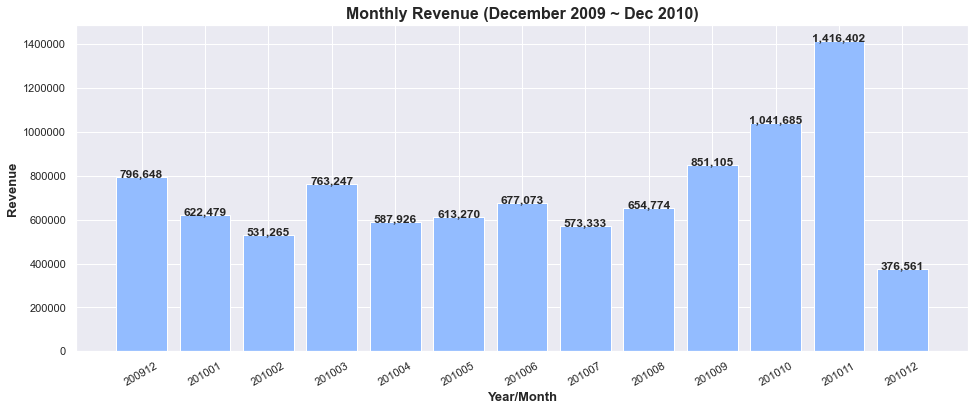

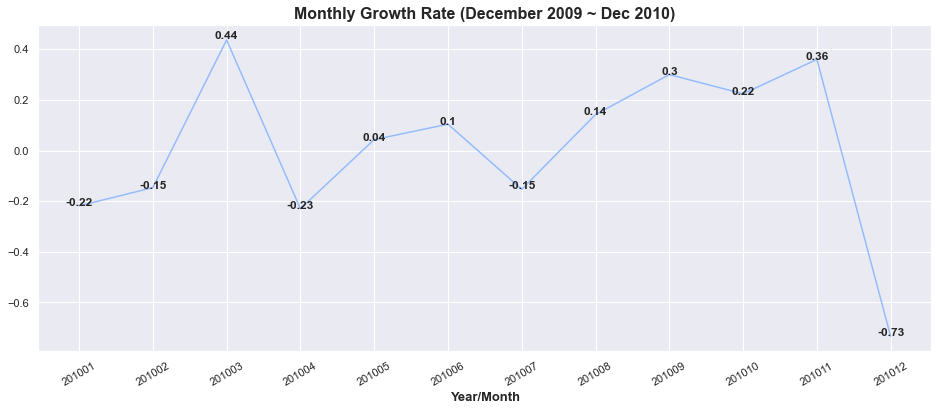

In [28]:
# Function for adding data labels
def addlabels(x,y, chart):
    if chart == 'bar':
        for i in range(len(x)):
            labels = format(int(y[i]), ',')
            plt.text(i, y[i], labels, ha = 'center', fontsize=12, weight = 'bold')
    else:
        for i in range(len(x)):
            plt.text(i, y[i], y[i], ha = 'center', fontsize=12, weight = 'bold')
    

# Monthly Revenue Bar Chart        
plt.figure(figsize= (16,6))

plt.ticklabel_format(style='plain')


plt.bar(monthly_summary.index, 
         monthly_summary['Revenue'], color = '#93bcff')
plt.xticks(rotation = 30)


bar_labels = [int(value) for value in monthly_summary['Revenue']]

addlabels(monthly_summary.index, bar_labels, 'bar')


plt.xlabel('Year/Month', size = 13, weight = 'bold')
plt.ylabel('Revenue', size = 13, weight = 'bold')
plt.title('Monthly Revenue (December 2009 ~ Dec 2010)', size = 16, weight = 'bold')




## Monthly Growth Rate Line Chart
plt.figure(figsize= (16,6))

plt.plot(monthly_summary.index[1:], 
         monthly_summary['MonthlyGrowthRate'][1:],
         color = '#93bcff'
        )
line_lebels = np.round(monthly_summary['MonthlyGrowthRate'],2)[1:]

addlabels(monthly_summary.index[1:],line_lebels, 'line')
plt.xticks(rotation = 30)

plt.xlabel('Year/Month', size = 13, weight = 'bold')

plt.title('Monthly Growth Rate (December 2009 ~ Dec 2010)', size = 16, weight = 'bold')


plt.show()

- The bar chart shows that the company's revenue fluctuated and it was increasing from December 2009 to November 2010. However, in December 2010, the revenue had a sudden drop by -73% compared to the previous month.

- The company made 1,041,685 and 1,416,402 in October and November, respectively, which is higher than the monthly revenue of other months.

- Also, the monthly revenue that the company made in December 2009 was 796,648, which is around two times higher compared to December 2010 (376,561).

- Analyzing the "Monthly Growth Rate" line chart, we can observe that the growth rate was negative only in January, February, April, and July.

In [29]:
tmp_df = retail_df[['Description','Revenue']].groupby('Description', as_index = False).sum()

In [30]:
tmp_df[tmp_df['Revenue'] <= 0 ]

Description       Revenue
6                            Bank Charges   -2068.96000
186                            AMAZON FEE  -39243.08000
322                       Adjust bad debt -136552.02000
323   Adjustment by Peter on 24/05/2010 1    -731.05000
395             BEWARE OF THE CAT DOORMAT       0.00000
568    BLUE GREEN CHRISTMAS HANGING BALL       -0.19000
652           BLUE TILED SET OF 3 DRAWERS       0.00000
687               BOX OF 3 PEBBLE CANDLES       0.00000
740                          Bank Charges  -26318.03000
858       CERAMIC CAKE TEAPOT WITH CHERRY      -3.55000
993               CIRCUS PARADE LUNCHBOX        0.00000
1076        CREAM SWEETHEART DOUBLE SHELF     -50.85000
1303                             Discount   -7788.32000
1310   Dotcomgiftshop Gift Voucher £80.00       0.00000
1383    ENGLISH ROSE DESIGN KITCHEN APRON     -11.90000
1386     ENGLISH ROSE DESIGN SHOPPING BAG       0.00000
1468                 FEATHER HEART LIGHTS     -20.00000
1781     GLASS JAR, ENGLISH CONFECTIONERY       0.00000
1921               HAND OPEN SHAPE CHROME     -10.17000
2162  KISS REINDEER SCANDINAVIAN STOCKING      -2.55000
2199        LARGE GLASS HEART TRINKET POT     -17.00000
2218  LARGE SILVER BALUSTRADE CANDLESTICK      -5.95000
2288            LITTLE FLOWER SHOPPER BAG       0.00000
2324               LUNCHBOX I LOVE LONDON       0.00000
2508         MULTICOLOUR FEATHERS CURTAIN       0.00000
2512           MULTICOLOUR POLKADOT PLATE       0.00000
2521                               Manual  -14125.34000
2721           PADS TO MATCH ALL CUSHIONS     -36.58600
2910             PINK EAR MUFF HEADPHONES     -14.79000
3174          PURPLE ORCHID FLOWER LIGHTS     -15.90000
3234           RED HEART CANDY POP LIGHTS      -9.90000
3488         S/16 BLACK SHINY/MAT BAUBLES     -29.40000
3526     S/4 HEART CRYSTAL FRIDGE MAGNETS      -4.95000
3552                              SAMPLES   -3016.41000
3601  SET 6 MINI SUSHI SET FRIDGE MAGNETS     -20.28000
3693    SET OF 6 SPICE TINS PANTRY DESIGN       0.00000
3711        SET OF KITCHEN WALL  STICKERS     -11.80000
3841                 SILVER CHERRY LIGHTS    -591.03000
3884                   SILVER WINE GOBLET       0.00000
4071  SWEETHEART CREAM STEEL FOLDIN CHAIR       0.00000
4168  TREE OF NOAH FESTIVE SCENTED CANDLE    -133.80000
4239      VINTAGE BLUE VACUUM FLASK 0.5L      -67.50000
4295               VINTAGE WOOD ORGANISER     -33.90000
4342                  WHITE CHERRY LIGHTS    -427.24000
4375           WHITE ORCHID FLOWER LIGHTS     -45.30000
4386   WHITE SCANDINAVIAN HEART CHRISTMAS     -13.75000
4463             WOODLAND CREATURES  WRAP       0.00000
4538         ZINC HEART HANGER WITH HOOKS      -4.25000

In [31]:
def exclude_val(df):
    exclude_values = ['Manual','Bank Charges',' Bank Charges','SAMPLES','Discount','Adjust bad debt','AMAZON FEE','POSTAGE',
                      21494,22467,22719,"Bank Charges","12'S SOLD AS 1?","17129c","21733 mixed","85123a mixed","?","?????","AMAZON FEE",
"Adjustment by Peter on 24/05/2010 1","Adjustment by john on 26/01/2010 16","Adjustment by john on 26/01/2010 16",
"Amazon sold as set","Bank Charges","Came as green?","DOTCOM SETS","Damaged","Damp and rusty","Discount","Donated to The Food Chain charity",
"Dotcom","Dotcom multiple","Dotcom multiples","Dotcom sales","Dotcom sold as set","Ebay sales by the box","Given away",
 "Incorrectly entered. should be 2279","MIA","MISSING","Mixed with blue","Rusty","Rusty connections","SAMPLES",
 "Sold as 17003?","Sold as C","Zebra invcing error","Wet, rusty-thrown away",'Zebra invcing error','bad quality','broken','broken glass','broken zips','broken, uneven bottom','cant find',
 'check','code mix up 72597','coding mix up','counted','crushed','damaged','damaged/dirty','damaged?','damages','damages etc','damages, lost bits etc',
 'damages?','damges','dirty','dirty, torn, thrown away.','discoloured','display','display stands','donated to the Food Chain charity.',
 'dotcom','dotcom sales','ebay sales','entry error','faulty','for show','given away','gone','incorrect credit','invcd as 84879?','invoice 506647',
 'lost','lost in space','lost?','missing','missing (wrongly coded?)','missing?','missings','mouldy','my error - connor',
 'non colour fast','phil said so','poor quality','reverse mistake','rex use','rust,missing sets etc','short', 'show',
 'show display','smashed','sold as 17003?','sold as D?','sold as gold','sold as set/6 on dotcom','sold in wrong qnty',
 'stock credited from royal yacht inc', 'stock take','used for show display','wedding co returns?','wet','wet & rotting',
 'wet and rotting','wet cartons','wet ctn','wet damages','wet/smashed/unsellable','wonky bottom/broken','wrong code',
 'wrong ctn size','amazon','amendment','checked','correct previous adjustment','debenhams','dotcom email','eurobargain invc/credit',
 'found','found again','mailout','mailout addition','tk maxx mix up with pink','update','wrong invc','?sold individually?','Carton qnty was 216 not 144 as stat',
'Ebay sales by the box.','Mailout','No Stock','Rust fixed','Rusty','Sold as A/B','temp','Found','Damages','Rusty ','Adjustment by john on 26/01/2010 17','Adjust bad debt', 'Adjustment by Peter on Jun 25 2010 ']
    drop_list = []
    for val in exclude_values:
        tmp_df = df[df['Description'] == val]
        idx = list(tmp_df.index)
        if len(idx) != 0:
            drop_list = drop_list + idx
    retail_df.drop(drop_list,inplace = True)
        
#In the column "Description," the company indicated as negative values, damage / missing products, 
#and services(such as amazon adjustment, bank charges), etc.
#From this point, as these values are not useful for my analysis, I will drop them.   
            

In [32]:
exclude_val(retail_df)

### Monthly Order Count and Monthly Active Customers

I will calculate the 'Monthly Order Count' and 'Monthly Active Customers.' to check the possible reason:
- 1) For the highest revenue in November and October.
- 2) For the sudden drop in revenue in December.
- 3) For the negative growth rate in January, February, April, and July.

In [33]:
monthly_OrderCount = retail_df[['Quantity','YearMonth']].copy()
monthly_active_customer = retail_df[['Customer ID','YearMonth']].copy()
monthly_active_customer = monthly_active_customer[monthly_active_customer['Customer ID'].isna() != True]

In [34]:
monthly_summary['MonthlyOrderCount'] = monthly_OrderCount.groupby('YearMonth').sum().values.squeeze()
monthly_summary['MonthlyActiveCustomers'] = monthly_active_customer.groupby('YearMonth').nunique().values.squeeze()

In [35]:
monthly_summary

Revenue  MonthlyGrowthRate  MonthlyOrderCount  \
YearMonth                                                       
200912     796648.50000                NaN             415329   
201001     622479.50200           -0.21863             387181   
201002     531265.36600           -0.14653             374942   
201003     763247.24100            0.43666             520867   
201004     587926.69200           -0.22970             360148   
201005     613270.72000            0.04311             378959   
201006     677073.87000            0.10404             390960   
201007     573333.69000           -0.15322             331649   
201008     654774.39000            0.14205             465746   
201009     851105.96100            0.29985             489192   
201010    1041685.61000            0.22392             608180   
201011    1416402.11200            0.35972             706560   
201012     376561.91000           -0.73414             168150   

           MonthlyActiveCustomers  
YearMonth                          
200912                       1041  
201001                        745  
201002                        803  
201003                       1094  
201004                        987  
201005                       1058  
201006                       1081  
201007                        984  
201008                        963  
201009                       1186  
201010                       1556  
201011                       1680  
201012                        620

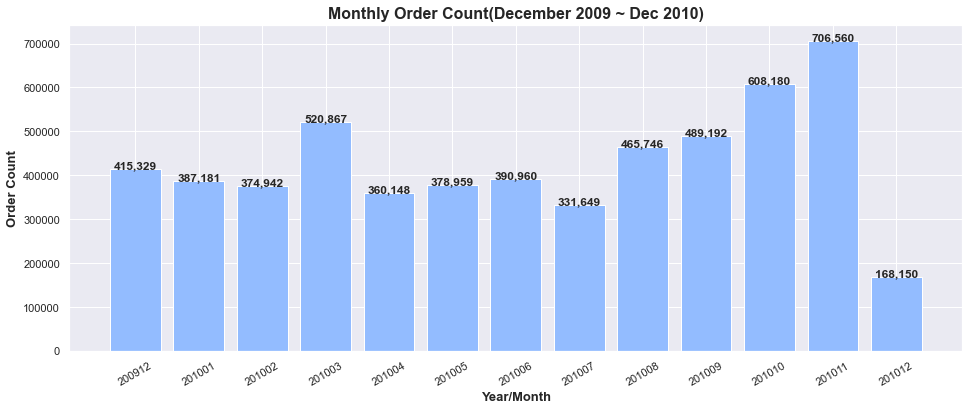

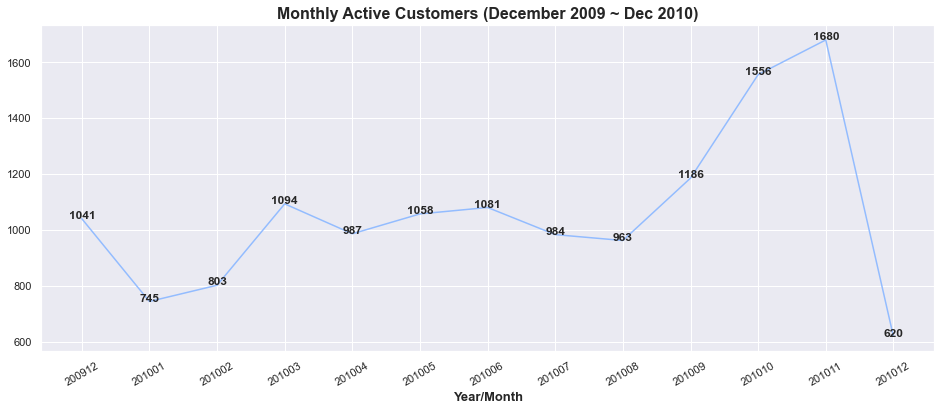

In [36]:
# Monthly Order Count Bar Chart
plt.figure(figsize= (16,6))

plt.ticklabel_format(style='plain')


plt.bar(monthly_summary.index, 
         monthly_summary['MonthlyOrderCount'], color = '#93bcff')
plt.xticks(rotation = 30)


bar_labels = [int(value) for value in monthly_summary['MonthlyOrderCount']]

addlabels(monthly_summary.index, bar_labels, 'bar' )


plt.xlabel('Year/Month', size = 13, weight = 'bold')
plt.ylabel('Order Count', size = 13, weight = 'bold')


plt.title('Monthly Order Count(December 2009 ~ Dec 2010)', size = 16, weight = 'bold')
plt.show()

# Monthly Active Customers
plt.figure(figsize= (16,6))

plt.plot(monthly_summary.index, 
         monthly_summary['MonthlyActiveCustomers'],
         color = '#93bcff'
        )
line_lebels = np.round(monthly_summary['MonthlyActiveCustomers'],2)

addlabels(monthly_summary.index,line_lebels, 'line')
plt.xticks(rotation = 30)

plt.xlabel('Year/Month', size = 13, weight = 'bold')

plt.title('Monthly Active Customers (December 2009 ~ Dec 2010)', size = 16, weight = 'bold')


plt.show()




Possible answers for the following reasons: 

1) The highest revenue in October and November.
2) The sudden drop in revenue in December.
3) The negative growth rate in January, February, April, and July.


**Answer # 1** The charts above illustrate that during October and November 2010, the number of active customers rose by over 1500, thus a possible reason for the increase in revenue. <br>An increase in sales and active customers can be the result of a successful marketing campaign, discounts, etc.
  
**Answer # 2** In December 2010, the number of active customers decreased dramatically to 620, which is around three times less than the previous month. <br>The possible reasons for low active customers and sales may be because the data of December is incomplete, or maybe the website was down, so customers could not access it.
    
**Answer # 3** Compared to other months, the monthly active customer and order count was lower in January, February, April, and July, which may be the possible reason for the negative monthly revenue growth rate.

### Products

In [37]:
retail_df

Invoice StockCode                          Description  Quantity  \
0       489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1       489434    79323P                   PINK CHERRY LIGHTS        12   
2       489434    79323W                  WHITE CHERRY LIGHTS        12   
3       489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4       489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   
...        ...       ...                                  ...       ...   
514618  538171     22271                 FELTCRAFT DOLL ROSIE         2   
514619  538171     22750         FELTCRAFT PRINCESS LOLA DOLL         1   
514620  538171     22751       FELTCRAFT PRINCESS OLIVIA DOLL         1   
514621  538171     20970   PINK FLORAL FELTCRAFT SHOULDER BAG         2   
514622  538171     21931               JUMBO STORAGE BAG SUKI         2   

               InvoiceDate   Price  Customer ID         Country  YearMonth  \
0      2009-12-01 07:45:00 6.95000  13085.00000  United Kingdom     200912   
1      2009-12-01 07:45:00 6.75000  13085.00000  United Kingdom     200912   
2      2009-12-01 07:45:00 6.75000  13085.00000  United Kingdom     200912   
3      2009-12-01 07:45:00 2.10000  13085.00000  United Kingdom     200912   
4      2009-12-01 07:45:00 1.25000  13085.00000  United Kingdom     200912   
...                    ...     ...          ...             ...        ...   
514618 2010-12-09 20:01:00 2.95000  17530.00000  United Kingdom     201012   
514619 2010-12-09 20:01:00 3.75000  17530.00000  United Kingdom     201012   
514620 2010-12-09 20:01:00 3.75000  17530.00000  United Kingdom     201012   
514621 2010-12-09 20:01:00 3.75000  17530.00000  United Kingdom     201012   
514622 2010-12-09 20:01:00 1.95000  17530.00000  United Kingdom     201012   

         Revenue  
0       83.40000  
1       81.00000  
2       81.00000  
3      100.80000  
4       30.00000  
...          ...  
514618   5.90000  
514619   3.75000  
514620   3.75000  
514621   7.50000  
514622   3.90000  

[512626 rows x 10 columns]

In [38]:
product_df = retail_df[['Description','Quantity','Price','InvoiceDate','Revenue']].copy()

### Top 15 - The Most Purchased Products and the Highest Revenue Generating Products
- It is always important to know which products are sold the most and which products bring more revenue.
<br>Products that are sold the most may not be the ones that generate the highest revenue.

In [39]:
prod_purchased_quant = product_df[['Description','Quantity']].groupby('Description').sum()
prod_purchased_quant = prod_purchased_quant.sort_values(by = 'Quantity', ascending = False)

In [40]:
prod_revenue = product_df[['Description','Revenue']].groupby('Description').sum()
prod_revenue = prod_revenue.sort_values(by = 'Revenue', ascending = False)

In [41]:
prod_purchased_quant[:15]

Quantity
Description                                  
WHITE HANGING HEART T-LIGHT HOLDER      57631
WORLD WAR 2 GLIDERS ASSTD DESIGNS       54443
BROCADE RING PURSE                      47637
PACK OF 72 RETRO SPOT CAKE CASES        46079
ASSORTED COLOUR BIRD ORNAMENT           44797
60 TEATIME FAIRY CAKE CASES             36172
PACK OF 60 PINK PAISLEY CAKE CASES      31687
JUMBO BAG RED RETROSPOT                 30666
SMALL POPCORN HOLDER                    29449
STRAWBERRY CERAMIC TRINKET BOX          26495
BLACK AND WHITE PAISLEY FLOWER MUG      25701
PACK OF 72 SKULL CAKE CASES             25353
PACK OF 12 SUKI TISSUES                 25162
GIRLS ALPHABET IRON ON PATCHES          23827
COLOUR GLASS T-LIGHT HOLDER HANGING     23642

In [42]:
prod_revenue[:15]

Revenue
Description                                     
REGENCY CAKESTAND 3 TIER            162885.71000
WHITE HANGING HEART T-LIGHT HOLDER  157580.28000
DOTCOM POSTAGE                      116401.99000
ASSORTED COLOUR BIRD ORNAMENT        72251.32000
PAPER CHAIN KIT 50'S CHRISTMAS       57808.25000
JUMBO BAG RED RETROSPOT              56329.56000
PARTY BUNTING                        49626.92000
ROTATING SILVER ANGELS T-LIGHT HLDR  47641.89000
JUMBO BAG STRAWBERRY                 36668.41000
EDWARDIAN PARASOL NATURAL            36422.16000
VINTAGE UNION JACK BUNTING           35717.71000
STRAWBERRY CERAMIC TRINKET BOX       33750.95000
JUMBO  BAG BAROQUE BLACK WHITE       32080.99000
EDWARDIAN PARASOL BLACK              32077.14000
JUMBO STORAGE BAG SUKI               31385.41000

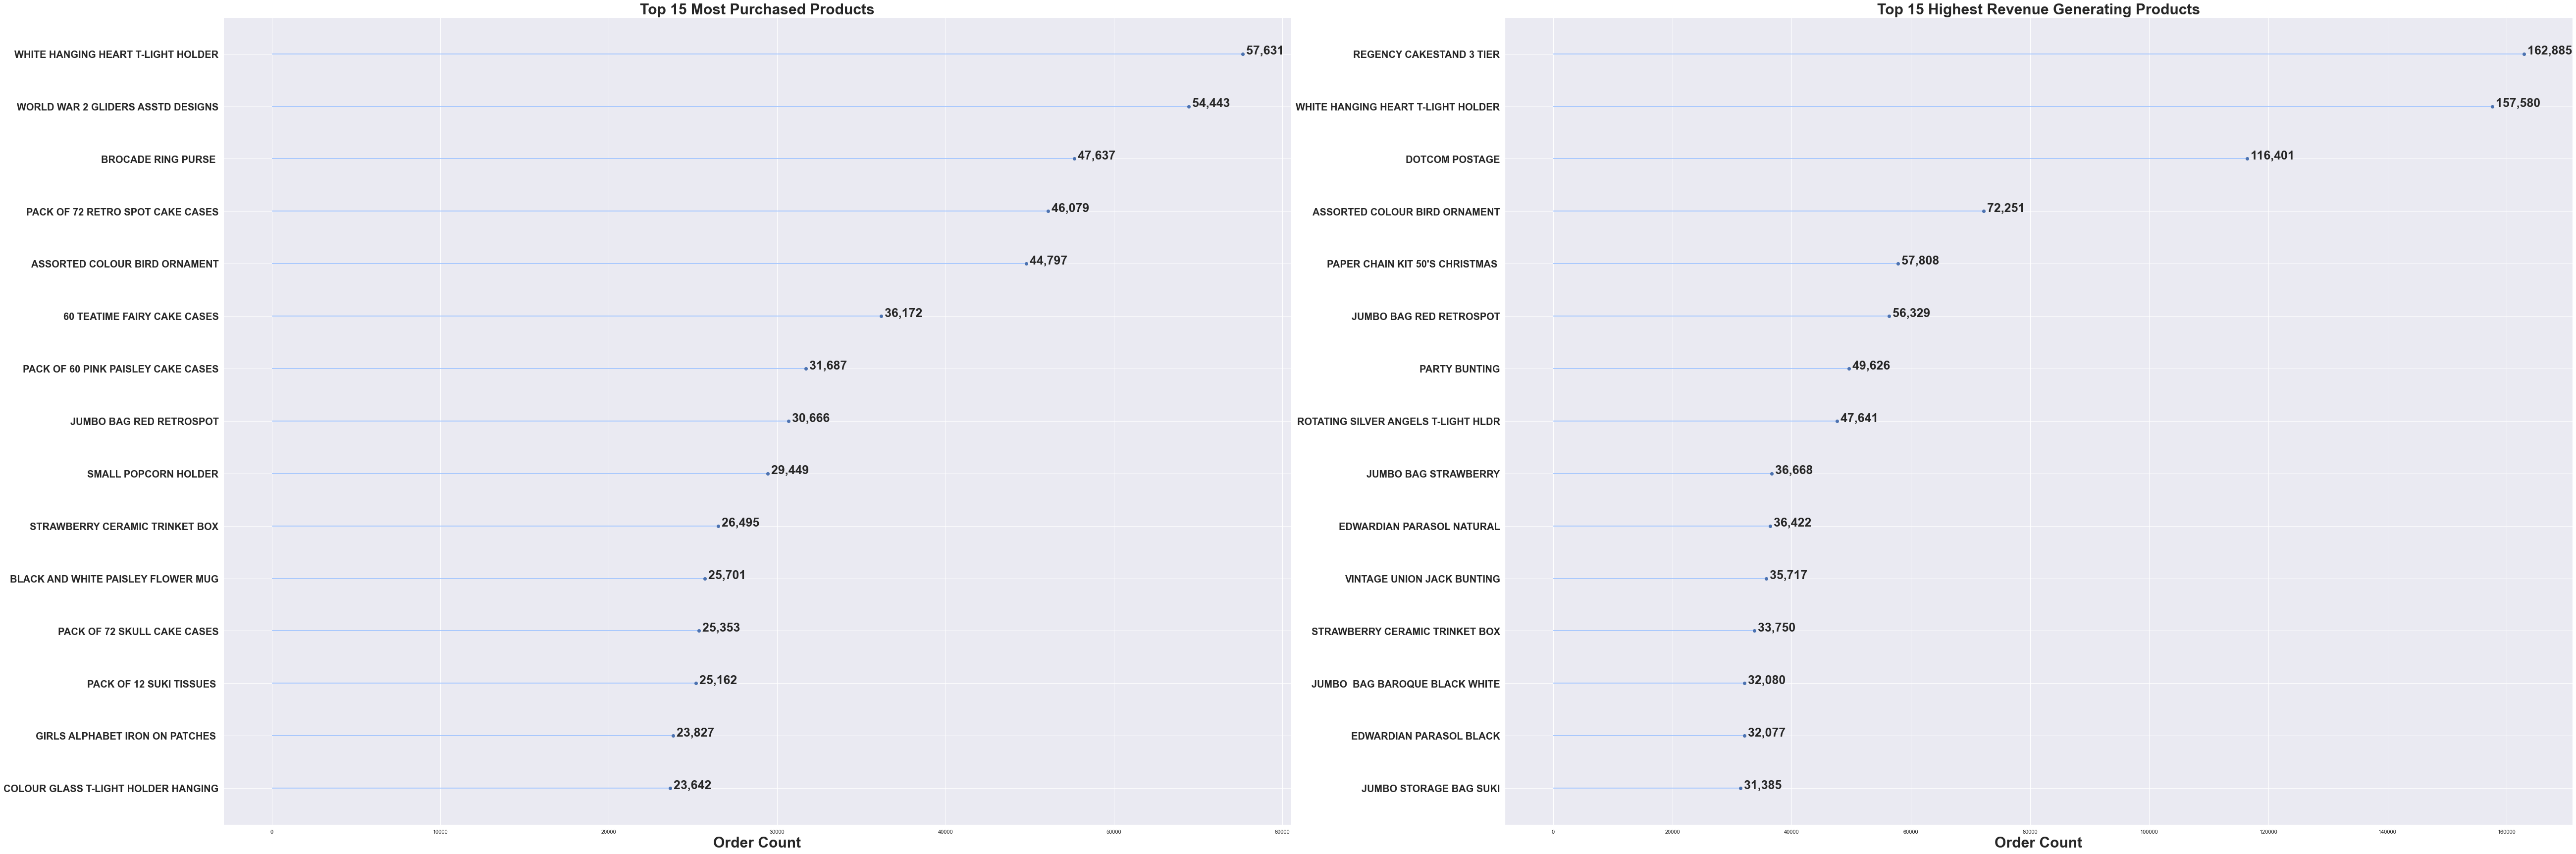

In [43]:
def subplot_add_label(x,y,ax):
    for x, y in zip(x,y):
        label = format(int(x), ',')
        ax.text(x, y, str(f' {label}'), fontsize=25, weight = 'bold')
        
    
f, (ax1, ax2 ) = plt.subplots(1, 2, sharey=False, figsize =(85,30))

# Sorting Data for Horizontal Lollipop Barplot
sorted_series_1  = prod_purchased_quant.sort_values('Quantity')['Quantity'][-15:]
sorted_series_2 = prod_revenue.sort_values('Revenue')['Revenue'][-15:]

my_range=range(0,len(sorted_series_1.index))

# Top 15 - The Most Purchased Products
ax1.hlines(y=sorted_series_1.index, xmin=0, xmax=sorted_series_1, color='#93bcff',linestyles= 'solid')
ax1.plot(sorted_series_1, my_range, "o")
subplot_add_label(sorted_series_1, sorted_series_1.index, ax1)
 

ax1.set_title(f'Top 15 Most Purchased Products',size = 30, weight = 'bold')
ax1.set_xlabel('Order Count',size = 30,weight = 'bold')
ax1.set_yticklabels(sorted_series_1.index,{'fontsize': 20,'fontweight': 'bold'})

# Top 15 - The Highest Revenue Generating Products
ax2.hlines(y=sorted_series_2.index, xmin=0, xmax=sorted_series_2, color='#93bcff',linestyles= 'solid')
ax2.plot(sorted_series_2, my_range, "o")
subplot_add_label(sorted_series_2, sorted_series_2.index, ax2)
 

ax2.set_title(f'Top 15 Highest Revenue Generating Products',size = 30, weight = 'bold')
ax2.set_xlabel('Order Count',size = 30,weight = 'bold')
ax2.set_yticklabels(sorted_series_2.index,{'fontsize': 20,'fontweight': 'bold'})

plt.show()





By looking at the chart **"Top 15 Most Purchased Products,"**  we can see that the following products have been purchased the most.

- WHITE HANGING HEART T-LIGHT HOLDER 
- WORLD WAR 2 GLIDERS ASSTD DESIGNS 
- BROCADE RING PURSE 
- PACK OF 72 RETRO SPOT CAKE CASES 
- ASSORTED COLOUR BIRD ORNAMENT 

However, it does not mean that these products brought the highest revenue.  
The chart **"Top 15 Highest Revenue Generating Products"** shows that not all products that were purchased the most generated the highest revenue.



In [44]:
# Creating a table that will show which places took each product from the "Top 15 Most Purchased Products" in the "Product Revenue" list
top_15_purchased = prod_purchased_quant.iloc[:15].copy()
top_15_purchased['Place_in_Most_Purchased_List'] = top_15_purchased.reset_index().index + 1
top_15_purchased['Place_in_Highest_Revenue_List'] = [prod_revenue.index.get_indexer([prod])[0]+1 for prod in top_15_purchased.index]
top_15_purchased['Revenue'] = prod_revenue.iloc[top_15_purchased['Place_in_Highest_Revenue_List'] - 1]
top_15_purchased = top_15_purchased[['Quantity','Revenue', 'Place_in_Most_Purchased_List', 'Place_in_Highest_Revenue_List']]

In [45]:
top_15_purchased

Quantity      Revenue  \
Description                                                  
WHITE HANGING HEART T-LIGHT HOLDER      57631 157580.28000   
WORLD WAR 2 GLIDERS ASSTD DESIGNS       54443  11276.21000   
BROCADE RING PURSE                      47637   8879.82000   
PACK OF 72 RETRO SPOT CAKE CASES        46079  23744.41000   
ASSORTED COLOUR BIRD ORNAMENT           44797  72251.32000   
60 TEATIME FAIRY CAKE CASES             36172  18059.15000   
PACK OF 60 PINK PAISLEY CAKE CASES      31687  16125.56000   
JUMBO BAG RED RETROSPOT                 30666  56329.56000   
SMALL POPCORN HOLDER                    29449  26779.20000   
STRAWBERRY CERAMIC TRINKET BOX          26495  33750.95000   
BLACK AND WHITE PAISLEY FLOWER MUG      25701   3281.15000   
PACK OF 72 SKULL CAKE CASES             25353  13224.61000   
PACK OF 12 SUKI TISSUES                 25162   8269.84000   
GIRLS ALPHABET IRON ON PATCHES          23827   4957.93000   
COLOUR GLASS T-LIGHT HOLDER HANGING     23642  14529.10000   

                                     Place_in_Most_Purchased_List  \
Description                                                         
WHITE HANGING HEART T-LIGHT HOLDER                              1   
WORLD WAR 2 GLIDERS ASSTD DESIGNS                               2   
BROCADE RING PURSE                                              3   
PACK OF 72 RETRO SPOT CAKE CASES                                4   
ASSORTED COLOUR BIRD ORNAMENT                                   5   
60 TEATIME FAIRY CAKE CASES                                     6   
PACK OF 60 PINK PAISLEY CAKE CASES                              7   
JUMBO BAG RED RETROSPOT                                         8   
SMALL POPCORN HOLDER                                            9   
STRAWBERRY CERAMIC TRINKET BOX                                 10   
BLACK AND WHITE PAISLEY FLOWER MUG                             11   
PACK OF 72 SKULL CAKE CASES                                    12   
PACK OF 12 SUKI TISSUES                                        13   
GIRLS ALPHABET IRON ON PATCHES                                 14   
COLOUR GLASS T-LIGHT HOLDER HANGING                            15   

                                     Place_in_Highest_Revenue_List  
Description                                                         
WHITE HANGING HEART T-LIGHT HOLDER                               2  
WORLD WAR 2 GLIDERS ASSTD DESIGNS                              160  
BROCADE RING PURSE                                             223  
PACK OF 72 RETRO SPOT CAKE CASES                                44  
ASSORTED COLOUR BIRD ORNAMENT                                    4  
60 TEATIME FAIRY CAKE CASES                                     68  
PACK OF 60 PINK PAISLEY CAKE CASES                              82  
JUMBO BAG RED RETROSPOT                                          6  
SMALL POPCORN HOLDER                                            30  
STRAWBERRY CERAMIC TRINKET BOX                                  12  
BLACK AND WHITE PAISLEY FLOWER MUG                             748  
PACK OF 72 SKULL CAKE CASES                                    129  
PACK OF 12 SUKI TISSUES                                        253  
GIRLS ALPHABET IRON ON PATCHES                                 498  
COLOUR GLASS T-LIGHT HOLDER HANGING                            107

- The table shows the **"Top 15 Most Purchased Products"** and which places they took in generating revenue.

  - For example, the company has sold over 20,000 pieces of the following products: **"GIRLS ALPHABET IRON ON PATCHES"** and **"BLACK AND WHITE PAISLEY FLOWER MUG,"** but these products took 498 and 748 places respectively, in generating revenue.
  <br>Therefore, when the company makes any decision related to products, it is not only enough to know which products were sold the most. It is also vital to know the total revenue generated by each product.

### Top 30 - The Most Purchased and the Highest Revenue Generating Products From  September to November

In [46]:
sep_nov_df = product_df[(product_df['InvoiceDate'] >= '2010-09-01' )&(product_df['InvoiceDate'] <= '2010-11-30')].copy()
prod_purchased_quant_sep_nov = sep_nov_df[['Description','Quantity']].groupby('Description').sum().sort_values('Quantity', ascending = False)
revenue_prod_sep_nov = sep_nov_df[['Description','Revenue']].groupby('Description').sum().sort_values('Revenue', ascending = False)

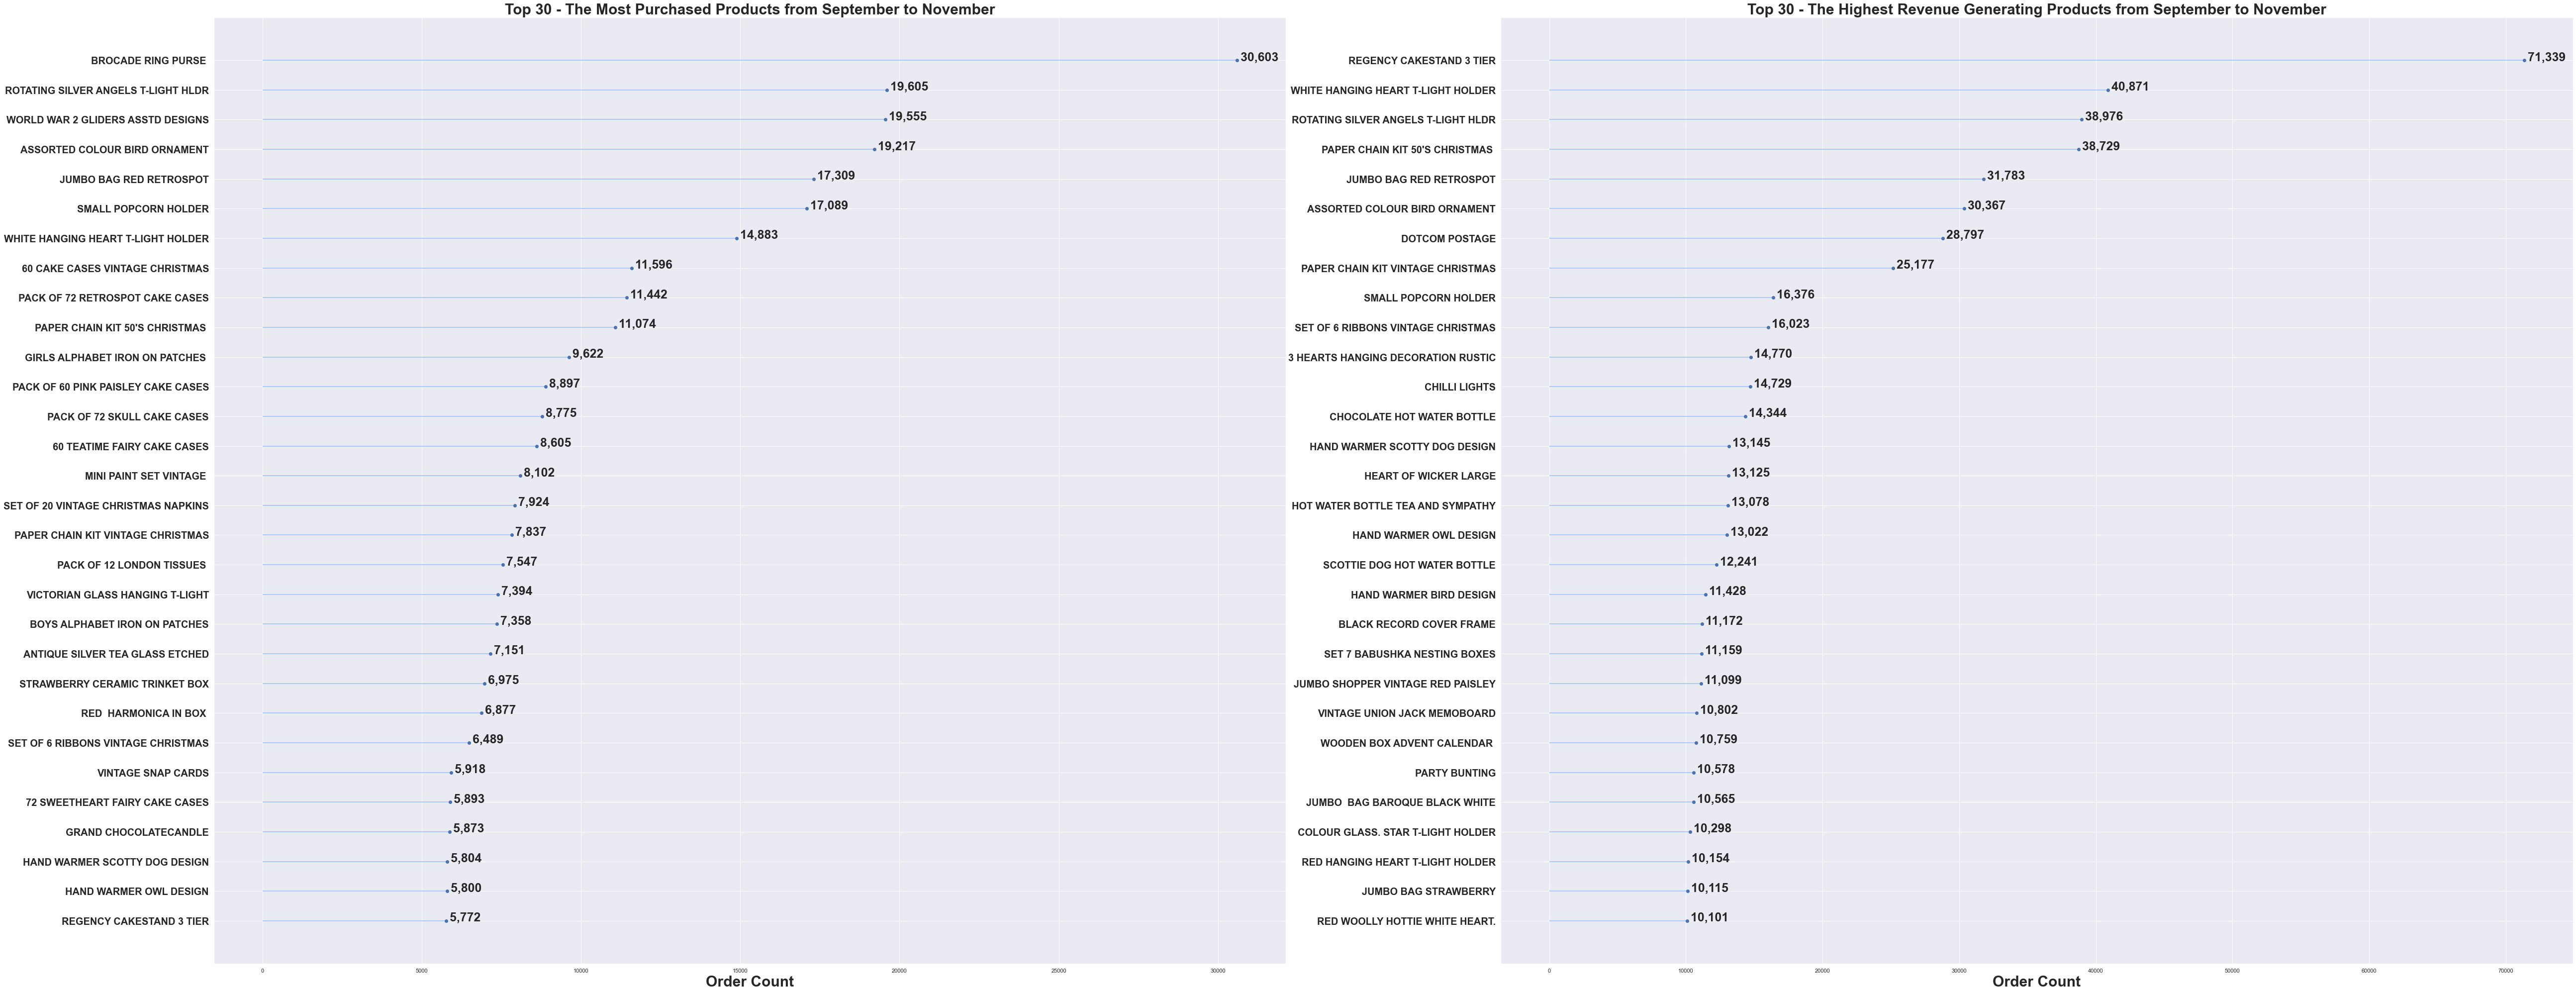

In [47]:
f, (ax1, ax2 ) = plt.subplots(1, 2, sharey=False, figsize =(85,35))

# Sorting Data for Horizontal Lollipop Barplot
sorted_series_1  = prod_purchased_quant_sep_nov.sort_values('Quantity')['Quantity'][-30:]
sorted_series_2 = revenue_prod_sep_nov.sort_values('Revenue')['Revenue'][-30:]

my_range=range(0,len(sorted_series_1.index))

# Top 30 - The Most Purchased Products from September to November
ax1.hlines(y=sorted_series_1.index, xmin=0, xmax=sorted_series_1, color='#93bcff',linestyles= 'solid')
ax1.plot(sorted_series_1, my_range, "o")
subplot_add_label(sorted_series_1, sorted_series_1.index, ax1)
 
ax1.set_title(f'Top 30 - The Most Purchased Products from September to November',size = 30, weight = 'bold')
ax1.set_xlabel('Order Count',size = 30,weight = 'bold')
ax1.set_yticklabels(sorted_series_1.index,{'fontsize': 20,'fontweight': 'bold'})

# Top 30 - The Highest Revenue Generating Products from September to November
ax2.hlines(y=sorted_series_2.index, xmin=0, xmax=sorted_series_2, color='#93bcff',linestyles= 'solid')
ax2.plot(sorted_series_2, my_range, "o")
subplot_add_label(sorted_series_2, sorted_series_2.index, ax2)
 
ax2.set_title(f'Top 30 - The Highest Revenue Generating Products from September to November',size = 30, weight = 'bold')
ax2.set_xlabel('Order Count',size = 30,weight = 'bold')
ax2.set_yticklabels(sorted_series_2.index,{'fontsize': 20,'fontweight': 'bold'})

plt.show()

By observing the charts above, we can see the Top 30 - the most purchased products and the highest revenue generating product from September to November. These graphs also show some seasonal products such as Christmas, hand warmer, etc. 

Up until now, what I calculated were the following:  
 - Monthy revenue 
 - Monthly growth rate 
 - Monthly Order Count 
 - Monthly Active Customers
 - Top 15 - The most Purchased Products
 - Top 15 - The Highest Revenue Generating Product
 - Top 30 - The Most Purchased Products from September to November.
 - Top 30 - The Highest Revenue Generating Products from September to November.

### Which country has purchased the most?

In [48]:
orders_per_country = retail_df[['Country','Invoice']].groupby('Country', as_index = False).count().sort_values('Invoice', ascending = False)
orders_per_country.rename(columns = {'Invoice' : 'OrderCount'}, inplace = True)

In [49]:
orders_per_country['Proportion%'] = (orders_per_country['OrderCount'] / orders_per_country['OrderCount'].sum()) * 100 

In [50]:
orders_per_country = orders_per_country[orders_per_country['Country'] != 'Unspecified'].reset_index(drop = True) 

In [51]:
orders_per_country['Country'].replace(to_replace = ['USA','RSA','EIRE','Korea'], value = ['United States of America','South Africa','Ireland','South Korea'], inplace=True)

### Map Visualisaion

#### Getting longitude and latitude of each location

In [52]:
from geopy.exc import GeocoderTimedOut
from geopy.geocoders import Nominatim

In [53]:
def findGeocode(location):
       
    try:
          
        geolocator = Nominatim(user_agent="alik@naver.com")
          
        return geolocator.geocode(location)
      
    except GeocoderTimedOut:
          
        return findGeocode(location)    
  



In [54]:
longitude = []
latitude = []

for i in tqdm(orders_per_country["Country"]):
      
    if findGeocode(i) != None:
           
        loc = findGeocode(i)
          
        latitude.append(loc.latitude)
        longitude.append(loc.longitude)
     
    else:
        latitude.append(np.nan)
        longitude.append(np.nan)

100%|██████████| 39/39 [00:53<00:00,  1.37s/it]


In [55]:
orders_per_country["longitude"] = longitude
orders_per_country["latitude"] = latitude

### Creating Map

In [56]:

import folium

# Making an empty map
m = folium.Map(location=[20,0],tiles="cartodbpositron", zoom_start=3 )


#Adding marker one by one on the map
for i in range(0,orders_per_country.shape[0]):
    country_name = orders_per_country.iloc[i]['Country']
    order_count = orders_per_country.iloc[i]['OrderCount']
    latitude = orders_per_country.iloc[i]['latitude']
    longitude = orders_per_country.iloc[i]['longitude']
    folium.Circle(
      location=[latitude,longitude],
      #popup=country_name,
      radius=float(order_count * 0.30),
      labels = True,
      color='crimson',
      fill=True,
      fill_color='crimson').add_child(folium.Popup(f"{country_name} has made: {format(order_count, ',')} orders",sticky= True,max_width = 250)).add_to(m)

m.save(outfile= "map.html")

m


In [58]:
orders_per_country

Country  OrderCount  Proportion%  longitude  latitude
0             United Kingdom      474006     92.46624   -3.27658  54.70235
1                    Ireland        9593      1.87134   -7.97946  52.86520
2                    Germany        7820      1.52548   10.42345  51.08342
3                     France        5567      1.08598    1.88833  46.60335
4                Netherlands        2691      0.52494    5.38721  52.15517
5                      Spain        1224      0.23877   -4.83798  39.32607
6                Switzerland        1161      0.22648    8.23197  46.79856
7                   Portugal        1069      0.20853   -7.88963  40.03326
8                    Belgium        1000      0.19507    4.66671  50.64028
9            Channel Islands         904      0.17635 -120.09190  33.96580
10                    Sweden         866      0.16893   14.52086  59.67497
11                     Italy         711      0.13870   12.67430  42.63843
12                 Australia         647      0.12621  134.75500 -24.77611
13                    Cyprus         544      0.10612   33.14513  34.98230
14                    Greece         516      0.10066   21.98771  38.99537
15                   Austria         514      0.10027   14.12456  47.59397
16      United Arab Emirates         427      0.08330   53.99948  24.00025
17                   Denmark         417      0.08135   10.33333  55.67025
18                    Norway         362      0.07062    9.09997  60.50002
19                   Finland         343      0.06691   25.92092  63.24678
20  United States of America         239      0.04662 -100.44588  39.78373
21                     Japan         223      0.04350  139.23942  36.57484
22                    Poland         193      0.03765   19.13442  52.21593
23                     Malta         168      0.03277   14.44769  35.88860
24                 Lithuania         154      0.03004   23.75000  55.35000
25                 Singapore         117      0.02282  103.81950   1.35711
26              South Africa         109      0.02126   24.99164 -28.81662
27                   Bahrain         107      0.02087   50.53446  26.15512
28                    Canada          77      0.01502 -107.99171  61.06669
29                  Thailand          76      0.01483  100.83273  14.89719
30                    Israel          74      0.01444   34.86677  31.53131
31                 Hong Kong          72      0.01405  114.16281  22.27933
32                   Iceland          71      0.01385  -18.10590  64.98418
33               South Korea          63      0.01229  127.69612  36.63839
34                    Brazil          62      0.01209  -53.20000 -10.33333
35               West Indies          54      0.01053    0.46179  50.83636
36                   Bermuda          34      0.00663  -64.75616  32.30382
37                   Nigeria          31      0.00605    7.99997   9.60004
38                   Lebanon          12      0.00234   35.84341  33.87506

The map and table above show that the United Kingdom made 92% of all purchases. Therefore, from now on, I will concentrate my analysis on this country. The following steps will be to find out: 

- Which products have been sold the most and generated the highest revenue each quarter in the UK? 

- Which **unique** products have been sold the most and generated the highest revenue each quarter in the UK? (By unique products, I mean products that the company sold only in a particular quarter.)

## United Kingdom

####  The Most Purchased and The Highest Revenue Generating Products in the United Kingdom

In [59]:
# Creating the United Kingdom DataFrame.
uk_product_df = retail_df[retail_df['Country'] == 'United Kingdom'].loc[:,['Description','Quantity','Price','InvoiceDate','Revenue']].copy()

In [60]:
# Dividing the United Kindom data by quarters.
quarter1_df = uk_product_df[(uk_product_df['InvoiceDate'] >= '2010-01-01')&(uk_product_df['InvoiceDate'] <= '2010-03-31')]
quarter2_df = uk_product_df[(uk_product_df['InvoiceDate'] >= '2010-04-01')&(uk_product_df['InvoiceDate'] <= '2010-06-30')]
quarter3_df = uk_product_df[(uk_product_df['InvoiceDate'] >= '2010-07-01')&(uk_product_df['InvoiceDate'] <= '2010-09-30')]
quarter4_df = uk_product_df[(uk_product_df['InvoiceDate'] >= '2010-10-01')&(uk_product_df['InvoiceDate'] <= '2010-12-31')]


In [61]:
quarter1_pro = quarter1_df[['Description','Revenue','Quantity']].groupby('Description').sum()
quarter2_pro = quarter2_df[['Description','Revenue','Quantity']].groupby('Description').sum()
quarter3_pro = quarter3_df[['Description','Revenue','Quantity']].groupby('Description').sum()
quarter4_pro = quarter4_df[['Description','Revenue','Quantity']].groupby('Description').sum()

In [62]:
# Calculating the purchased quantity of each product quarterly.
q1_pro_purchased_quant = quarter1_pro['Quantity'].sort_values(ascending = False)
q2_pro_purchased_quant = quarter2_pro['Quantity'].sort_values(ascending = False)
q3_pro_purchased_quant = quarter3_pro['Quantity'].sort_values(ascending = False)
q4_pro_purchased_quant = quarter4_pro['Quantity'].sort_values(ascending = False)


# Calculating the revenue of each product quarterly.
prod_revenue_q1 = quarter1_pro['Revenue'].sort_values(ascending = False)
prod_revenue_q2 = quarter2_pro['Revenue'].sort_values(ascending = False)
prod_revenue_q3 = quarter3_pro['Revenue'].sort_values(ascending = False)
prod_revenue_q4 = quarter4_pro['Revenue'].sort_values(ascending = False)

### Unique Products

####  The Most Purchased and The Highest Revenue Generating *Unique* Products in the United Kingdom

In [63]:
# Lambda Function that finds out unique products of each quarter.
find_uniq = lambda find_uniq_in, compare_1, compare_2,compare_3: set(find_uniq_in) - set.union(set(compare_1),set(compare_2),set(compare_3))

In [64]:
# Finding the unique products that the company sold only in a particular quarter.
uniq_pro_q1 = list(find_uniq(quarter1_pro.index,quarter2_pro.index,quarter3_pro.index,quarter4_pro.index))
uniq_pro_q2 = list(find_uniq(quarter2_pro.index,quarter1_pro.index,quarter3_pro.index,quarter4_pro.index))
uniq_pro_q3 = list(find_uniq(quarter3_pro.index,quarter1_pro.index,quarter2_pro.index,quarter4_pro.index))
uniq_pro_q4 = list(find_uniq(quarter4_pro.index,quarter1_pro.index,quarter2_pro.index,quarter3_pro.index))

In [65]:
# Calculating the purchased quantity of each unique product quarterly.
q1_uniqprod_purchased_quant = quarter1_pro.loc[uniq_pro_q1,'Quantity'].sort_values(ascending = False)
q2_uniqprod_purchased_quant = quarter2_pro.loc[uniq_pro_q2,'Quantity'].sort_values(ascending = False)
q3_uniqprod_purchased_quant = quarter3_pro.loc[uniq_pro_q3,'Quantity'].sort_values(ascending = False)
q4_uniqprod_purchased_quant = quarter4_pro.loc[uniq_pro_q4,'Quantity'].sort_values(ascending = False)

In [66]:
# Calculating the revenue of each unique product quarterly.
uniqprod_revenue_q1 = quarter1_pro.loc[uniq_pro_q1,'Revenue'].sort_values(ascending = False)
uniqprod_revenue_q2 = quarter2_pro.loc[uniq_pro_q2,'Revenue'].sort_values(ascending = False)
uniqprod_revenue_q3 = quarter3_pro.loc[uniq_pro_q3,'Revenue'].sort_values(ascending = False)
uniqprod_revenue_q4 = quarter4_pro.loc[uniq_pro_q4,'Revenue'].sort_values(ascending = False)

### Function to Visualise Quarterly Data.
It will be comfortable to create a function that visualizes the product data rather than re-writing the same visualizing code repeatedly.

In [67]:
def subplot_add_label(x,y,ax):
    for x, y in zip(x,y):
        label = format(int(x), ',')
        ax.text(x, y, str(f' {label}'), fontsize=25, weight = 'bold')
        
        
        
def quarter_barh_viz(seriese_1, series_2, title: int, quarter: int):
    
    """ 
        title = '0':The  Most Purchased / '1' The Hight Revenue Generating
         
    """
    
    f, (ax1, ax2 ) = plt.subplots(1, 2, sharey=False, figsize =(85,35))

    #Sorting Data for Horisontal Bar Chart
    sorted_series_1  = seriese_1.sort_values()[-30:]
    sorted_series_2 = series_2.sort_values()[-30:]



    ax1.barh(sorted_series_1.index, sorted_series_1, color = '#93bcff')
    subplot_add_label(sorted_series_1, sorted_series_1.index, ax1)
    if title == 0:
        ax1.set_title(f'Top 30 - The Most Purchased Products in UK (Quarter {quarter})',size = 30, weight = 'bold')
        ax1.set_xlabel('Order Count',size = 20,weight = 'bold')
    if title == 1:
        ax1.set_title(f'Top 30 - The Highest Revenue Generating Products in UK (Quarter {quarter})',size = 30, weight = 'bold')
        ax1.set_xlabel('Revenue Count',size = 20,weight = 'bold')
    ax1.set_yticklabels(sorted_series_1.index,{'fontsize': 20,'fontweight': 'bold'})


 
    ax2.barh(sorted_series_2.index, sorted_series_2, color = '#93bcff')
    subplot_add_label(sorted_series_2, sorted_series_2.index, ax2)
    if title == 0:
        ax2.set_title(f'Top 30 - The Most Purchased Unique Products in UK (Quarter {quarter})',size = 30, weight = 'bold')
        ax2.set_xlabel('Order Count',size = 20,weight = 'bold')
    if title == 1:
        ax2.set_title(f'Top 30 - The Highest Revenue Generating Unique Products in UK (Quarter {quarter})',size = 30, weight = 'bold')
        ax2.set_xlabel('Revenue Count',size = 20,weight = 'bold')
    ax2.set_yticklabels(sorted_series_2.index,{'fontsize': 20,'fontweight': 'bold'})

    return plt.show()

### Top 30 - Most Purchased and Highest Revenue Generating Products & Unique Products  Quarterly.

###  Quarter 1

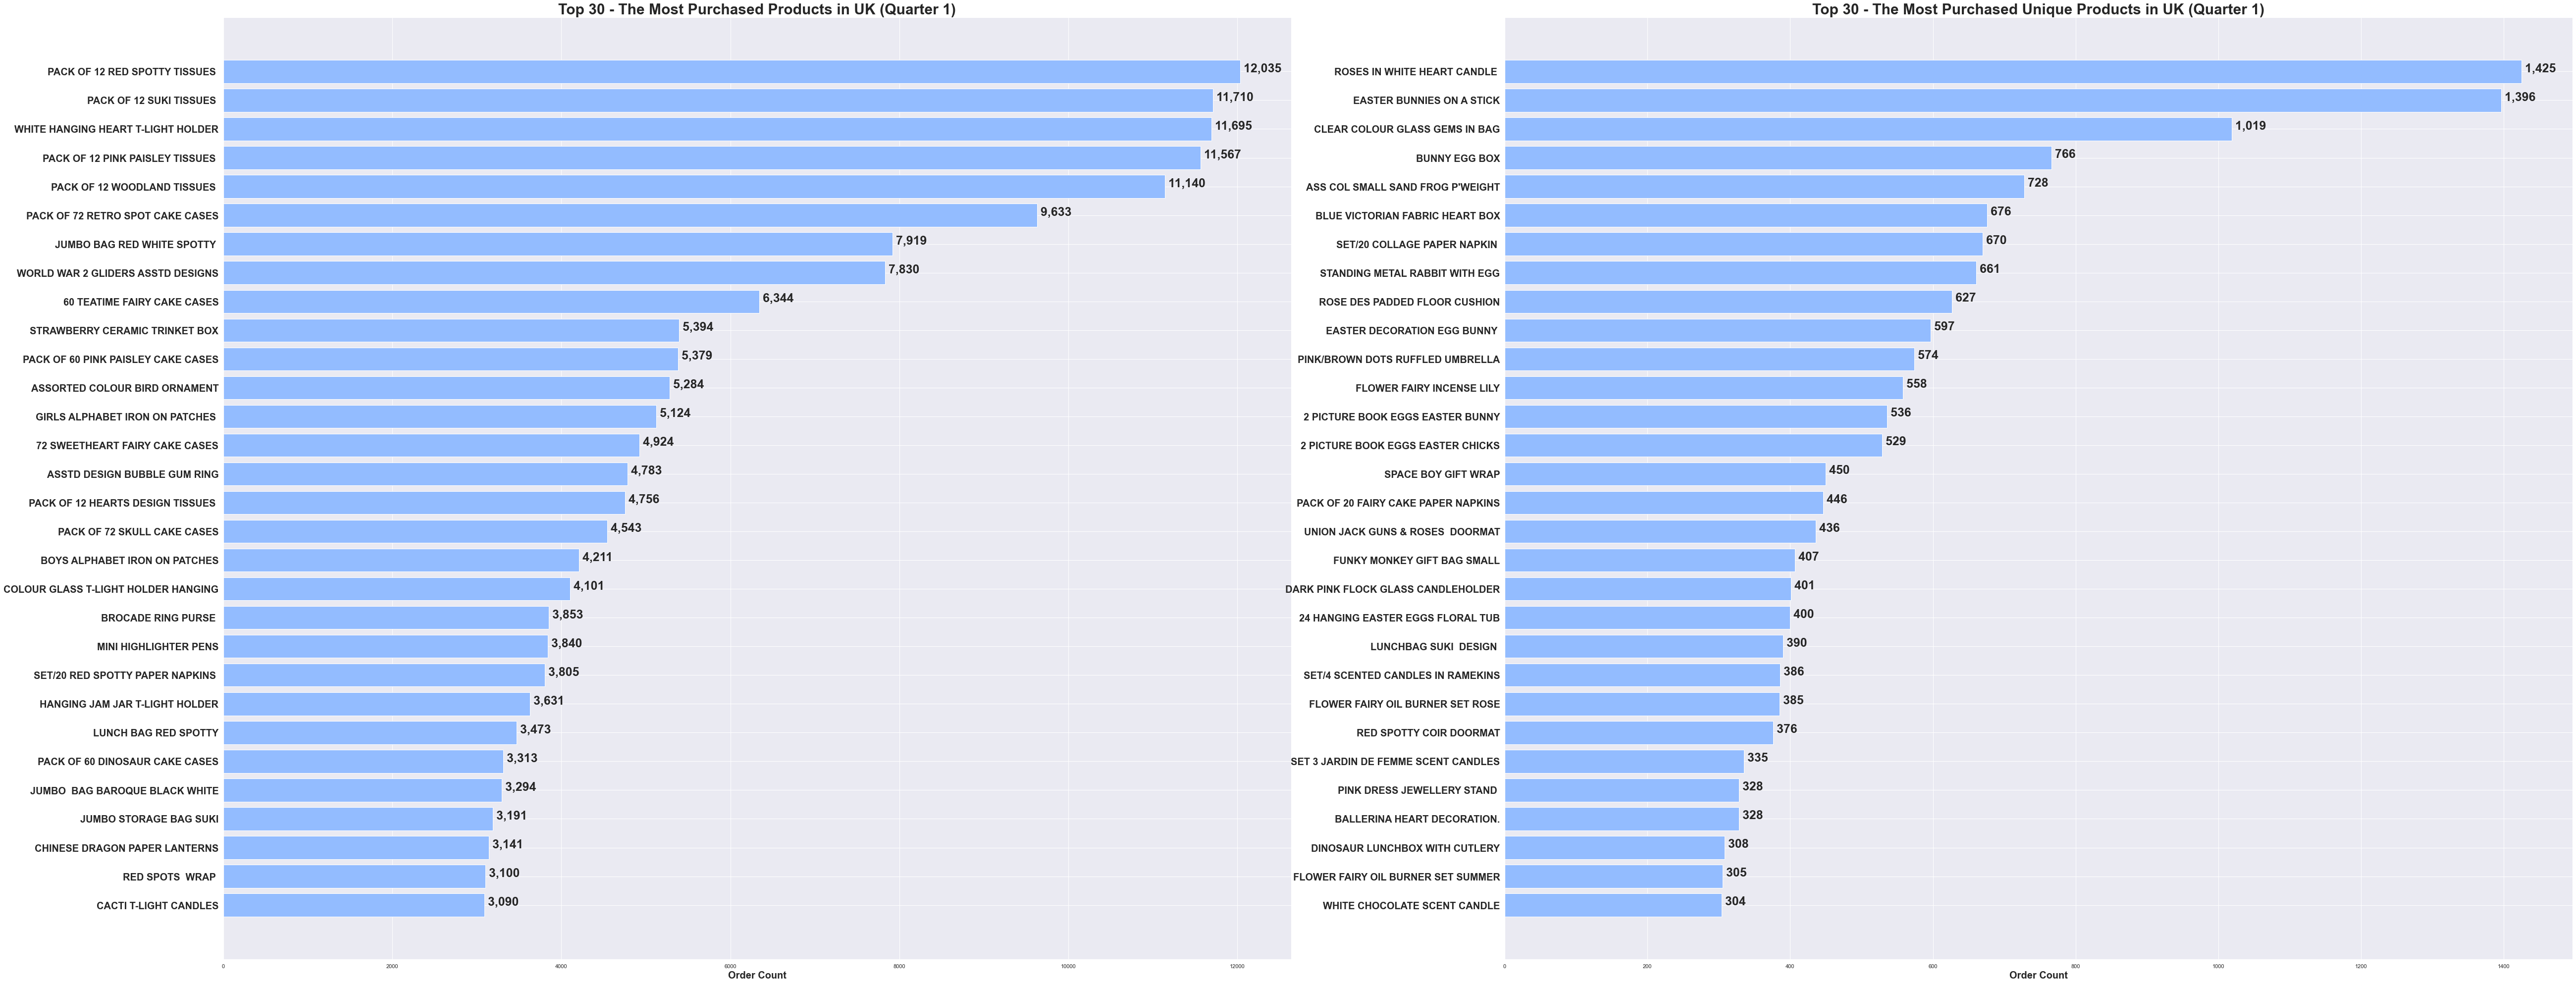

      _____________________________________________________________________________________________________________


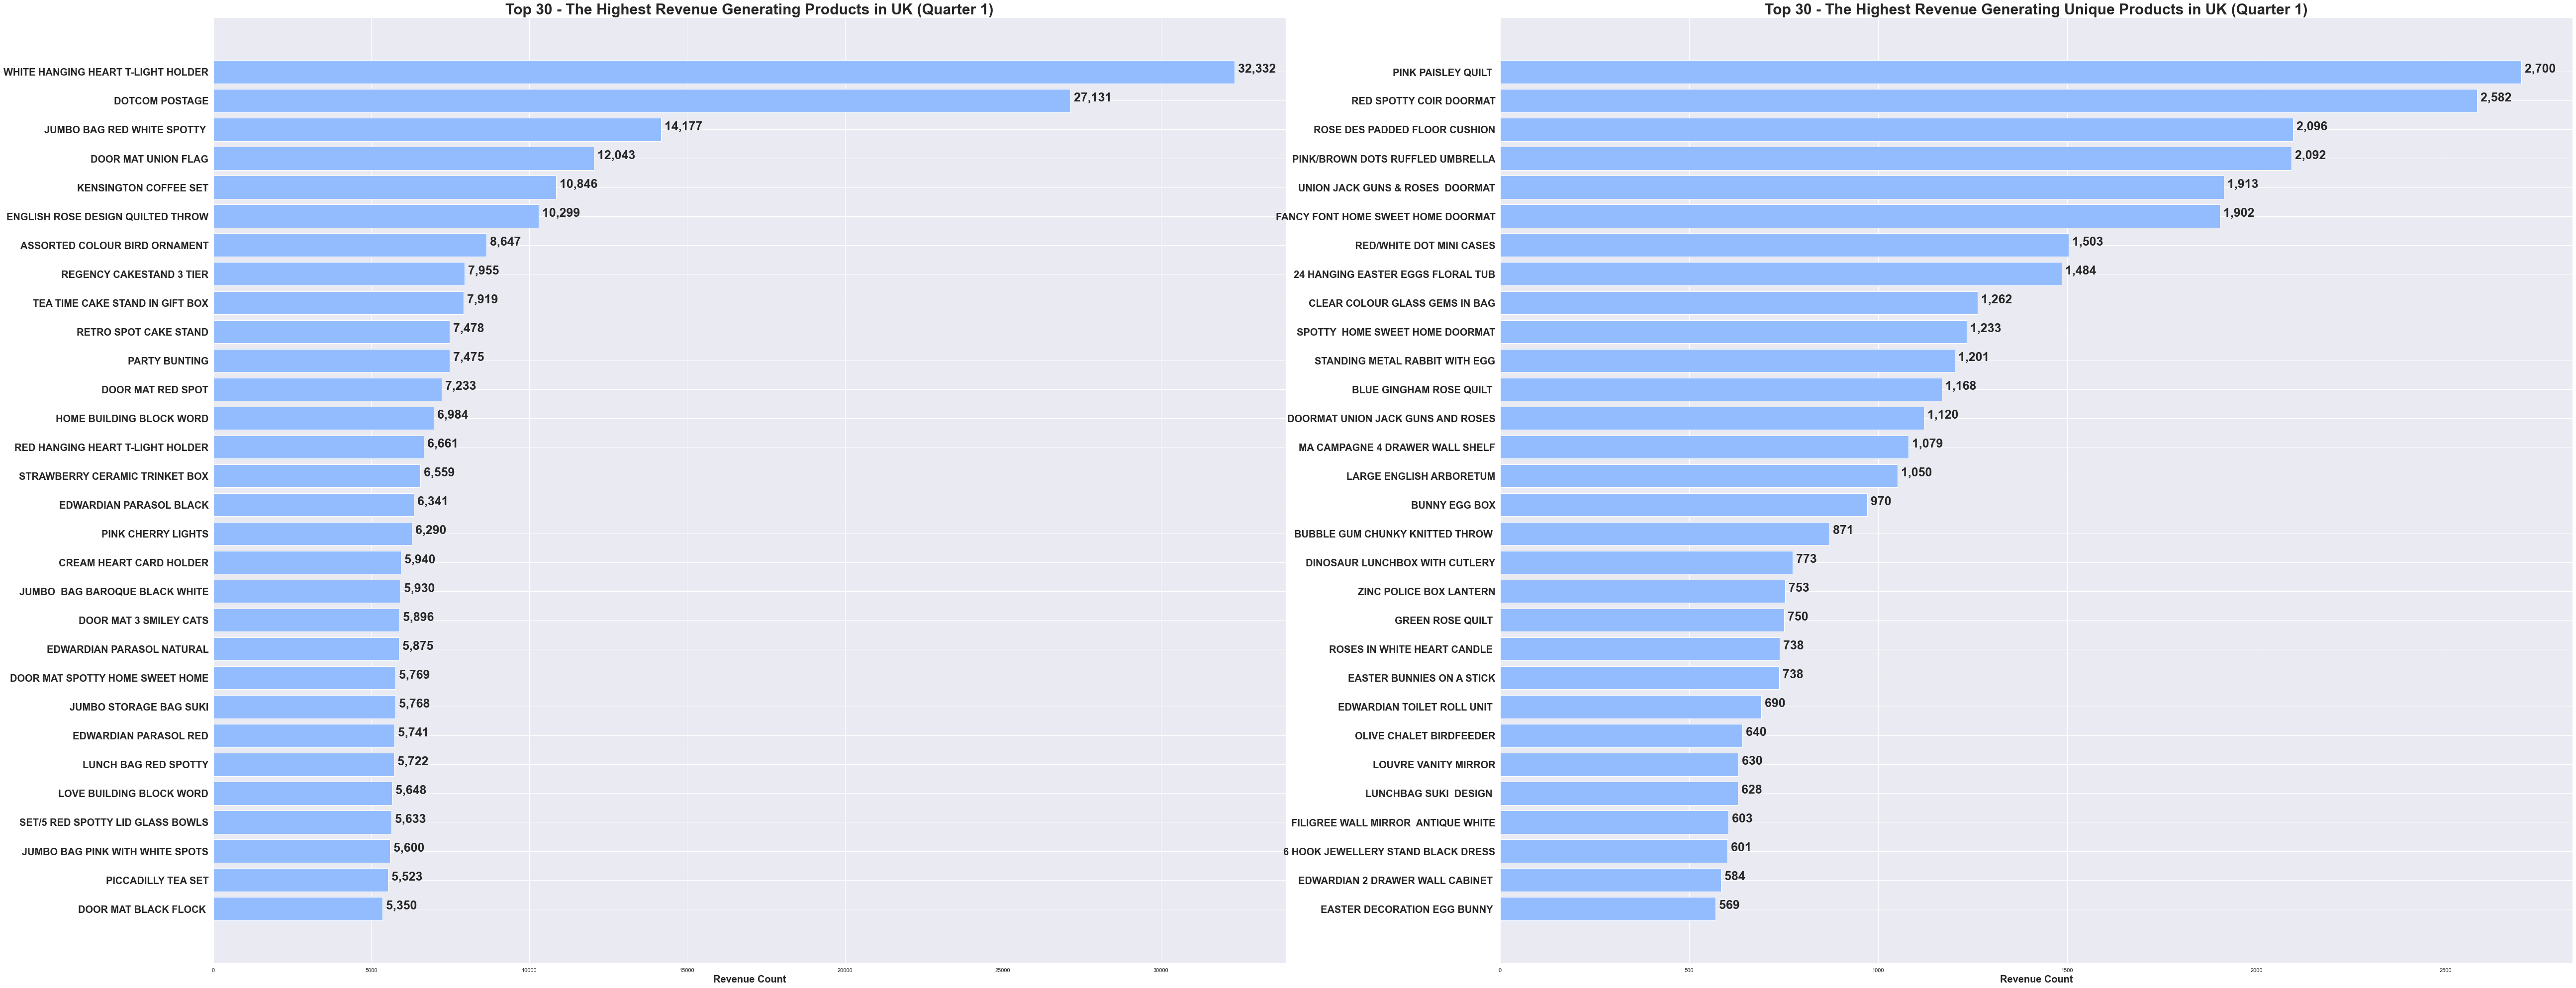

In [68]:
quarter_barh_viz(q1_pro_purchased_quant,q1_uniqprod_purchased_quant, 0, 1)
print('      _____________________________________________________________________________________________________________')
quarter_barh_viz(prod_revenue_q1,uniqprod_revenue_q1, 1, 1)

### Quarter 2

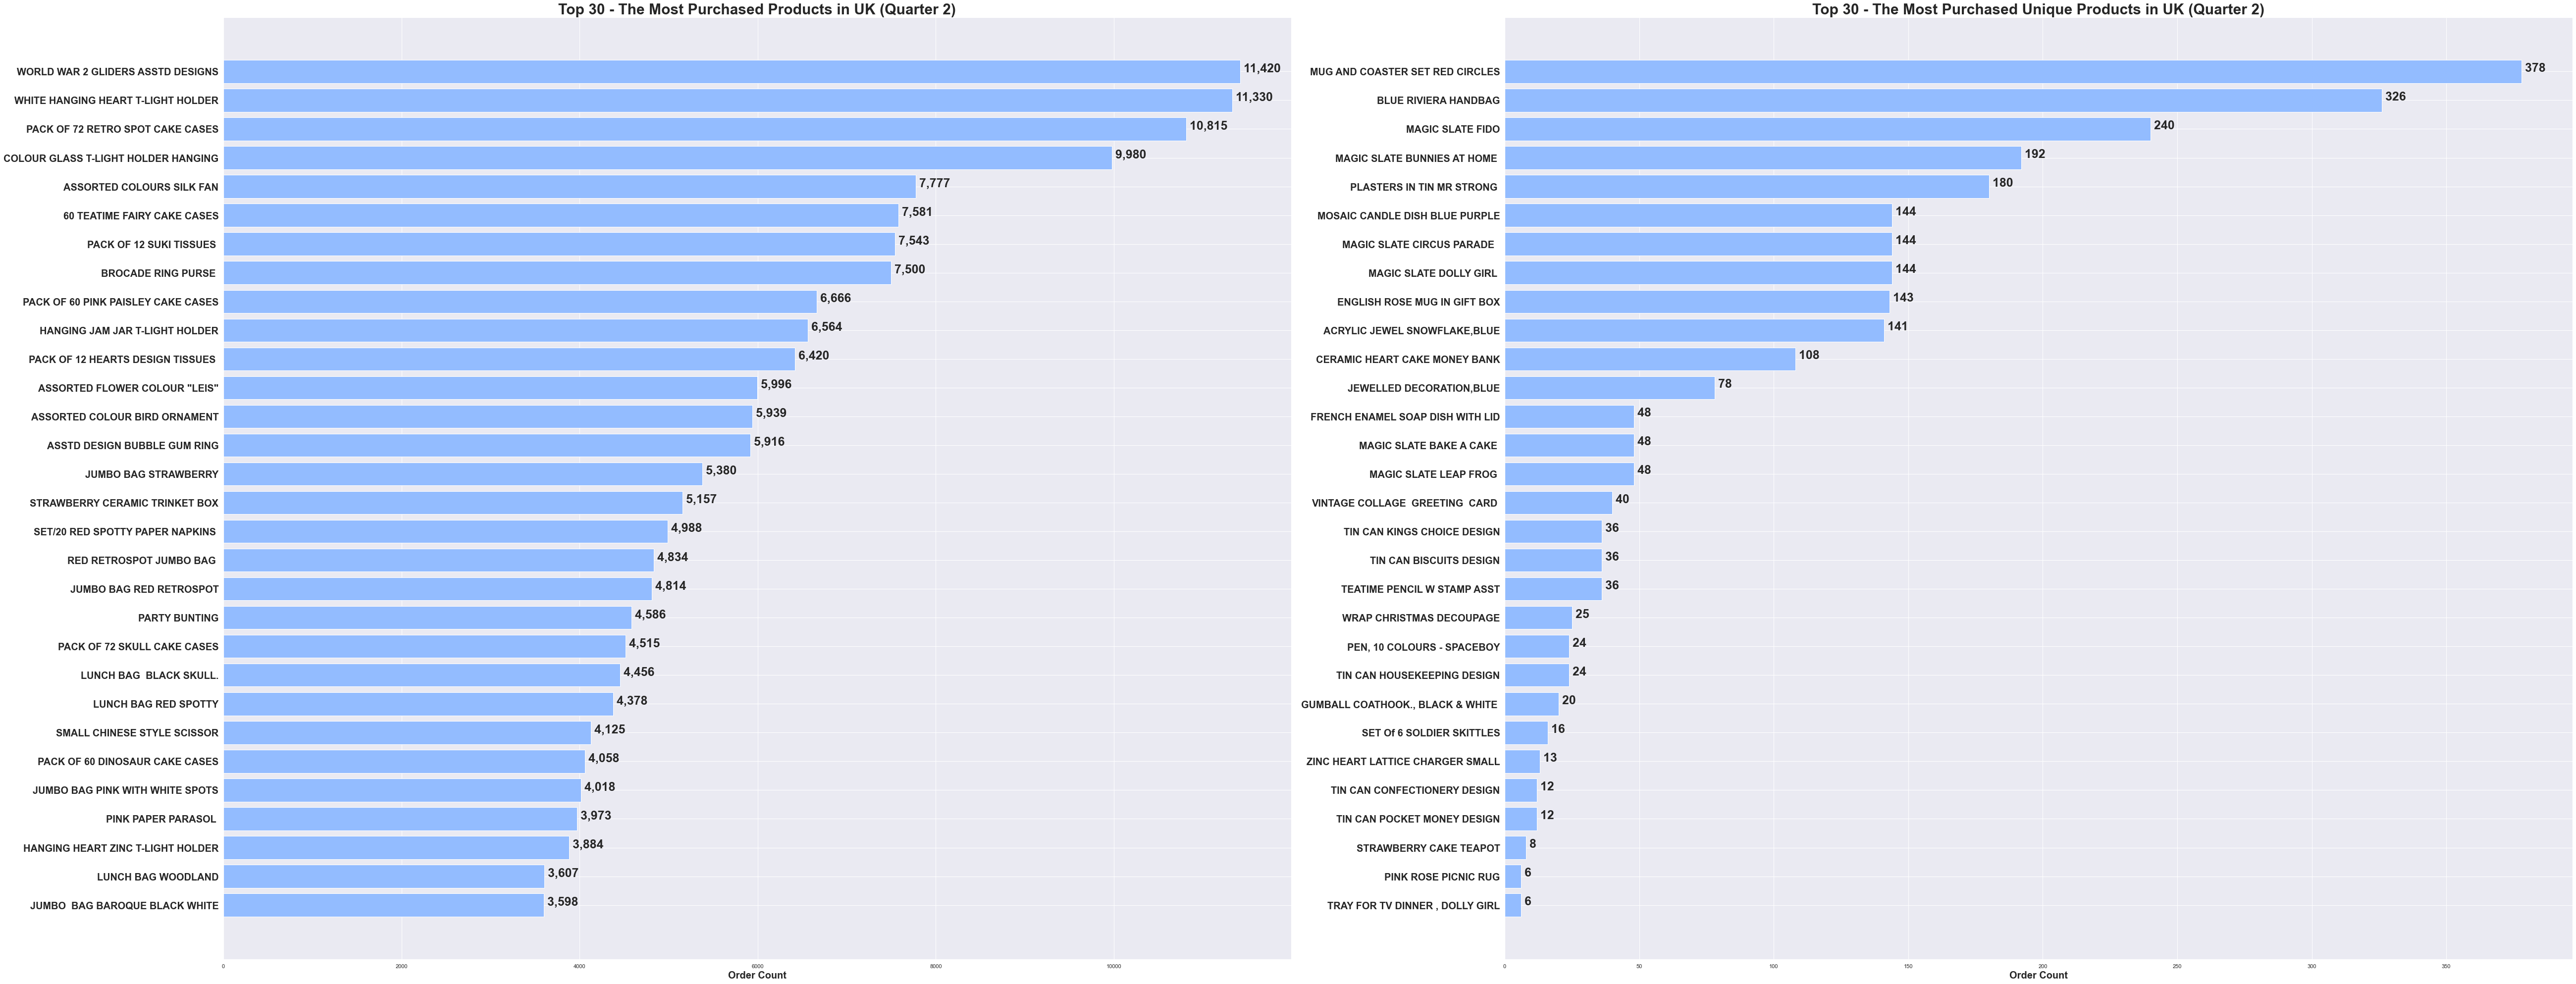

      _____________________________________________________________________________________________________________


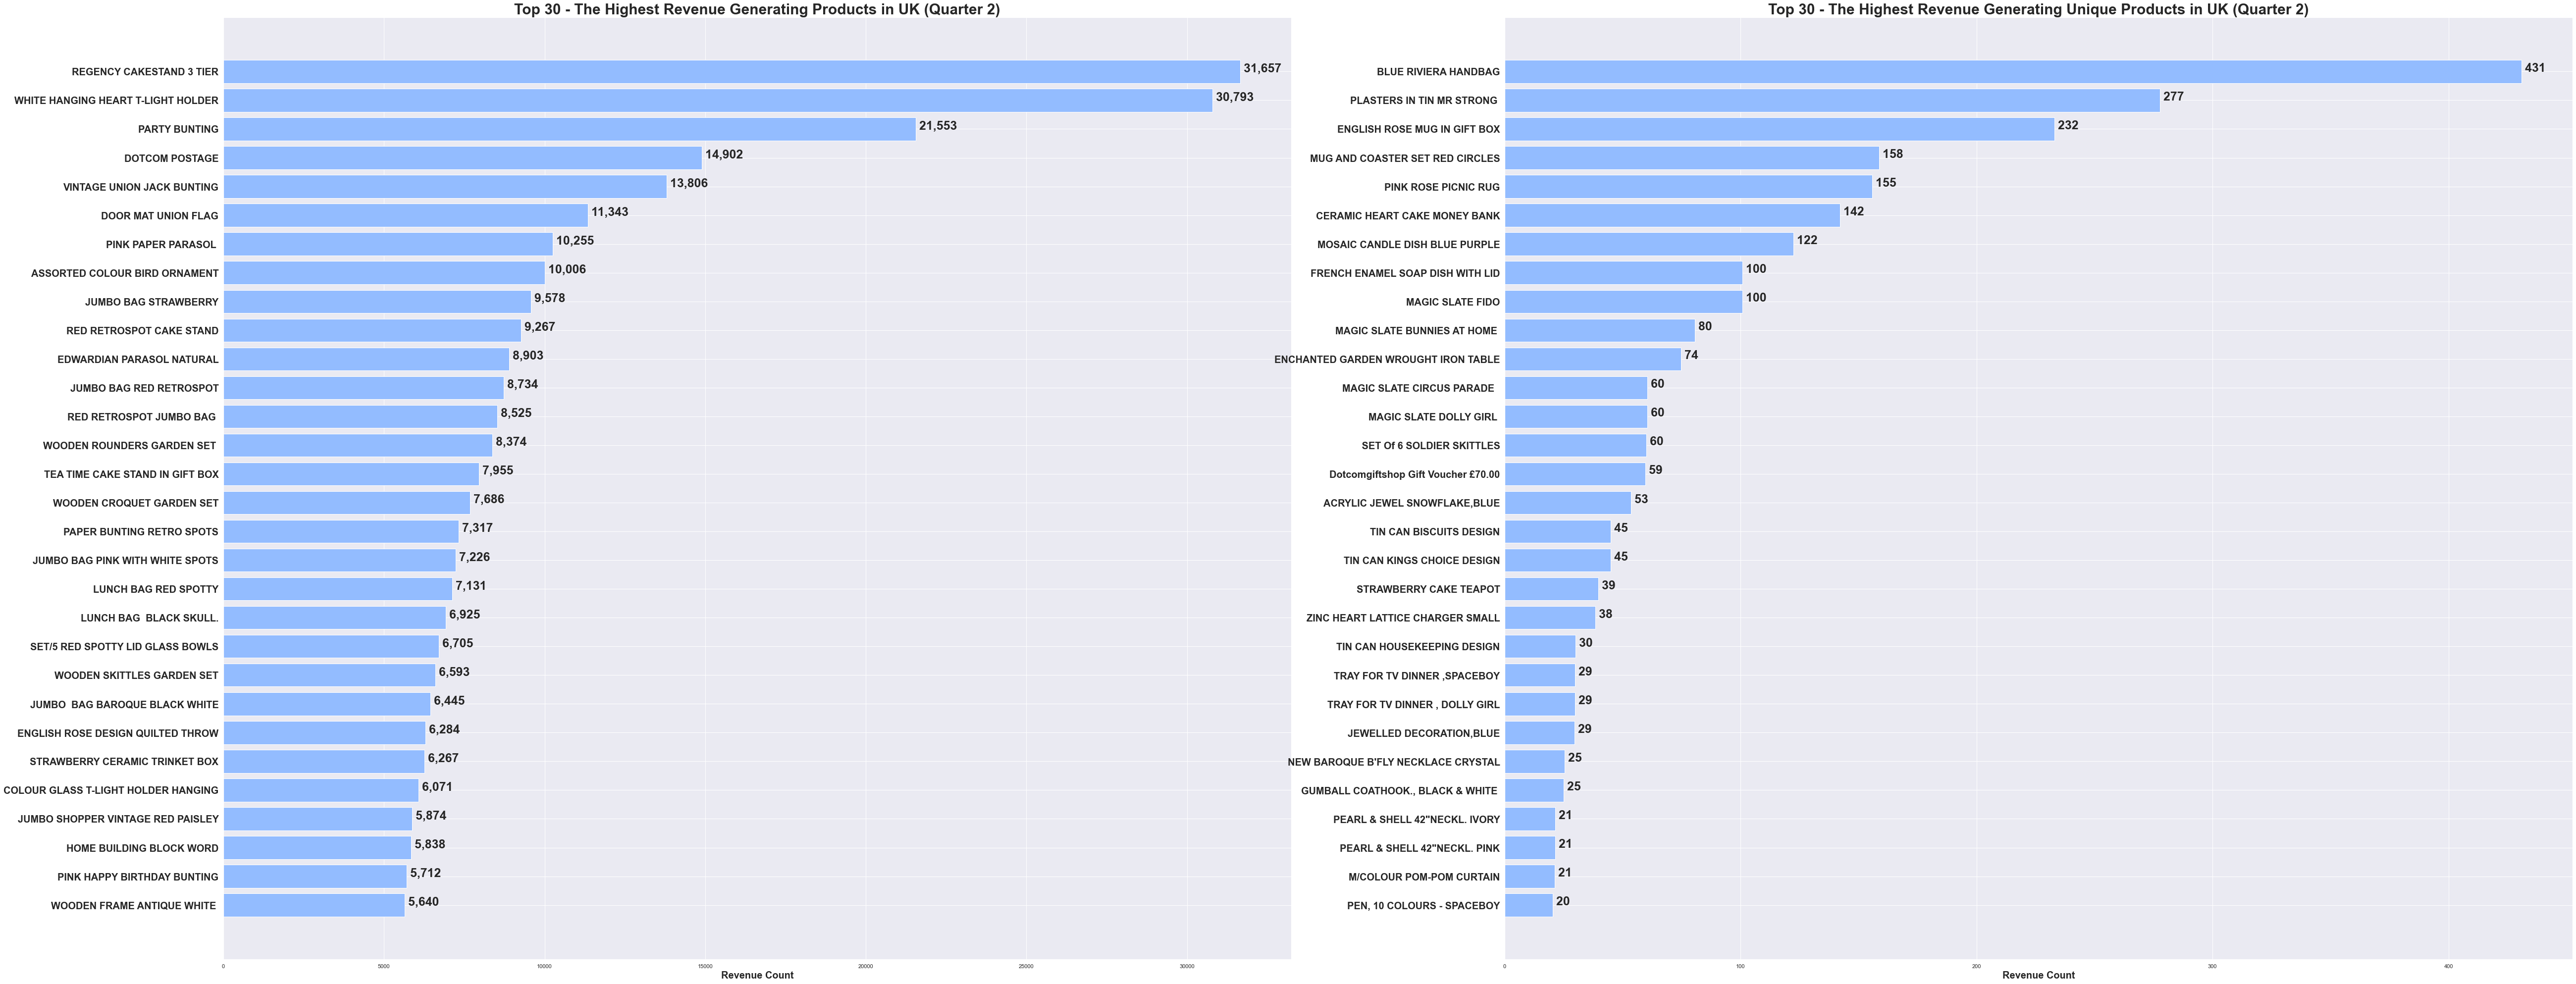

In [69]:
quarter_barh_viz(q2_pro_purchased_quant,q2_uniqprod_purchased_quant, 0, 2)
print('      _____________________________________________________________________________________________________________')
quarter_barh_viz(prod_revenue_q2,uniqprod_revenue_q2, 1, 2)

### Quarter 3

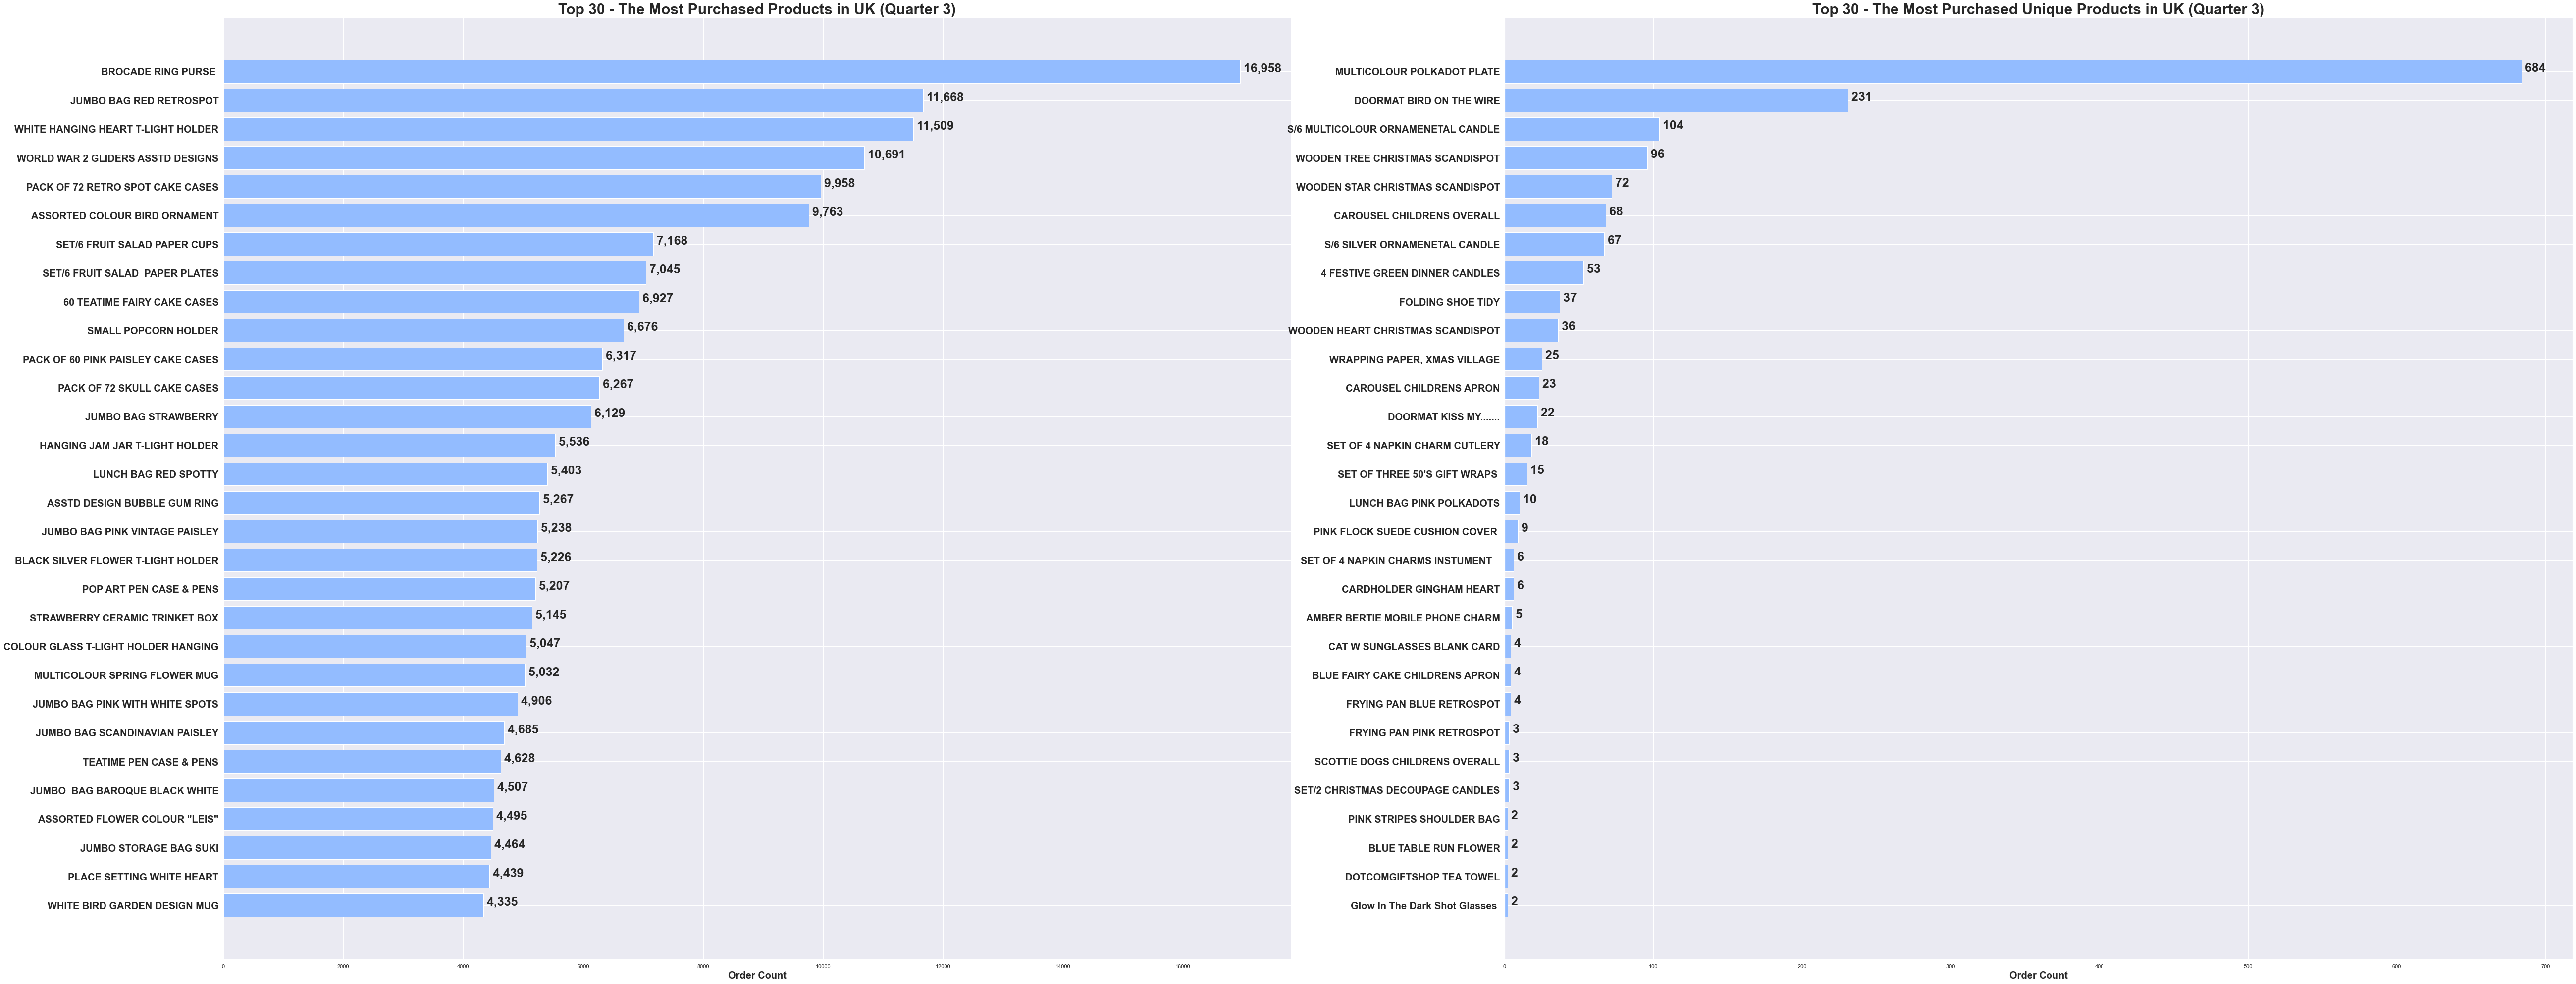

      _____________________________________________________________________________________________________________


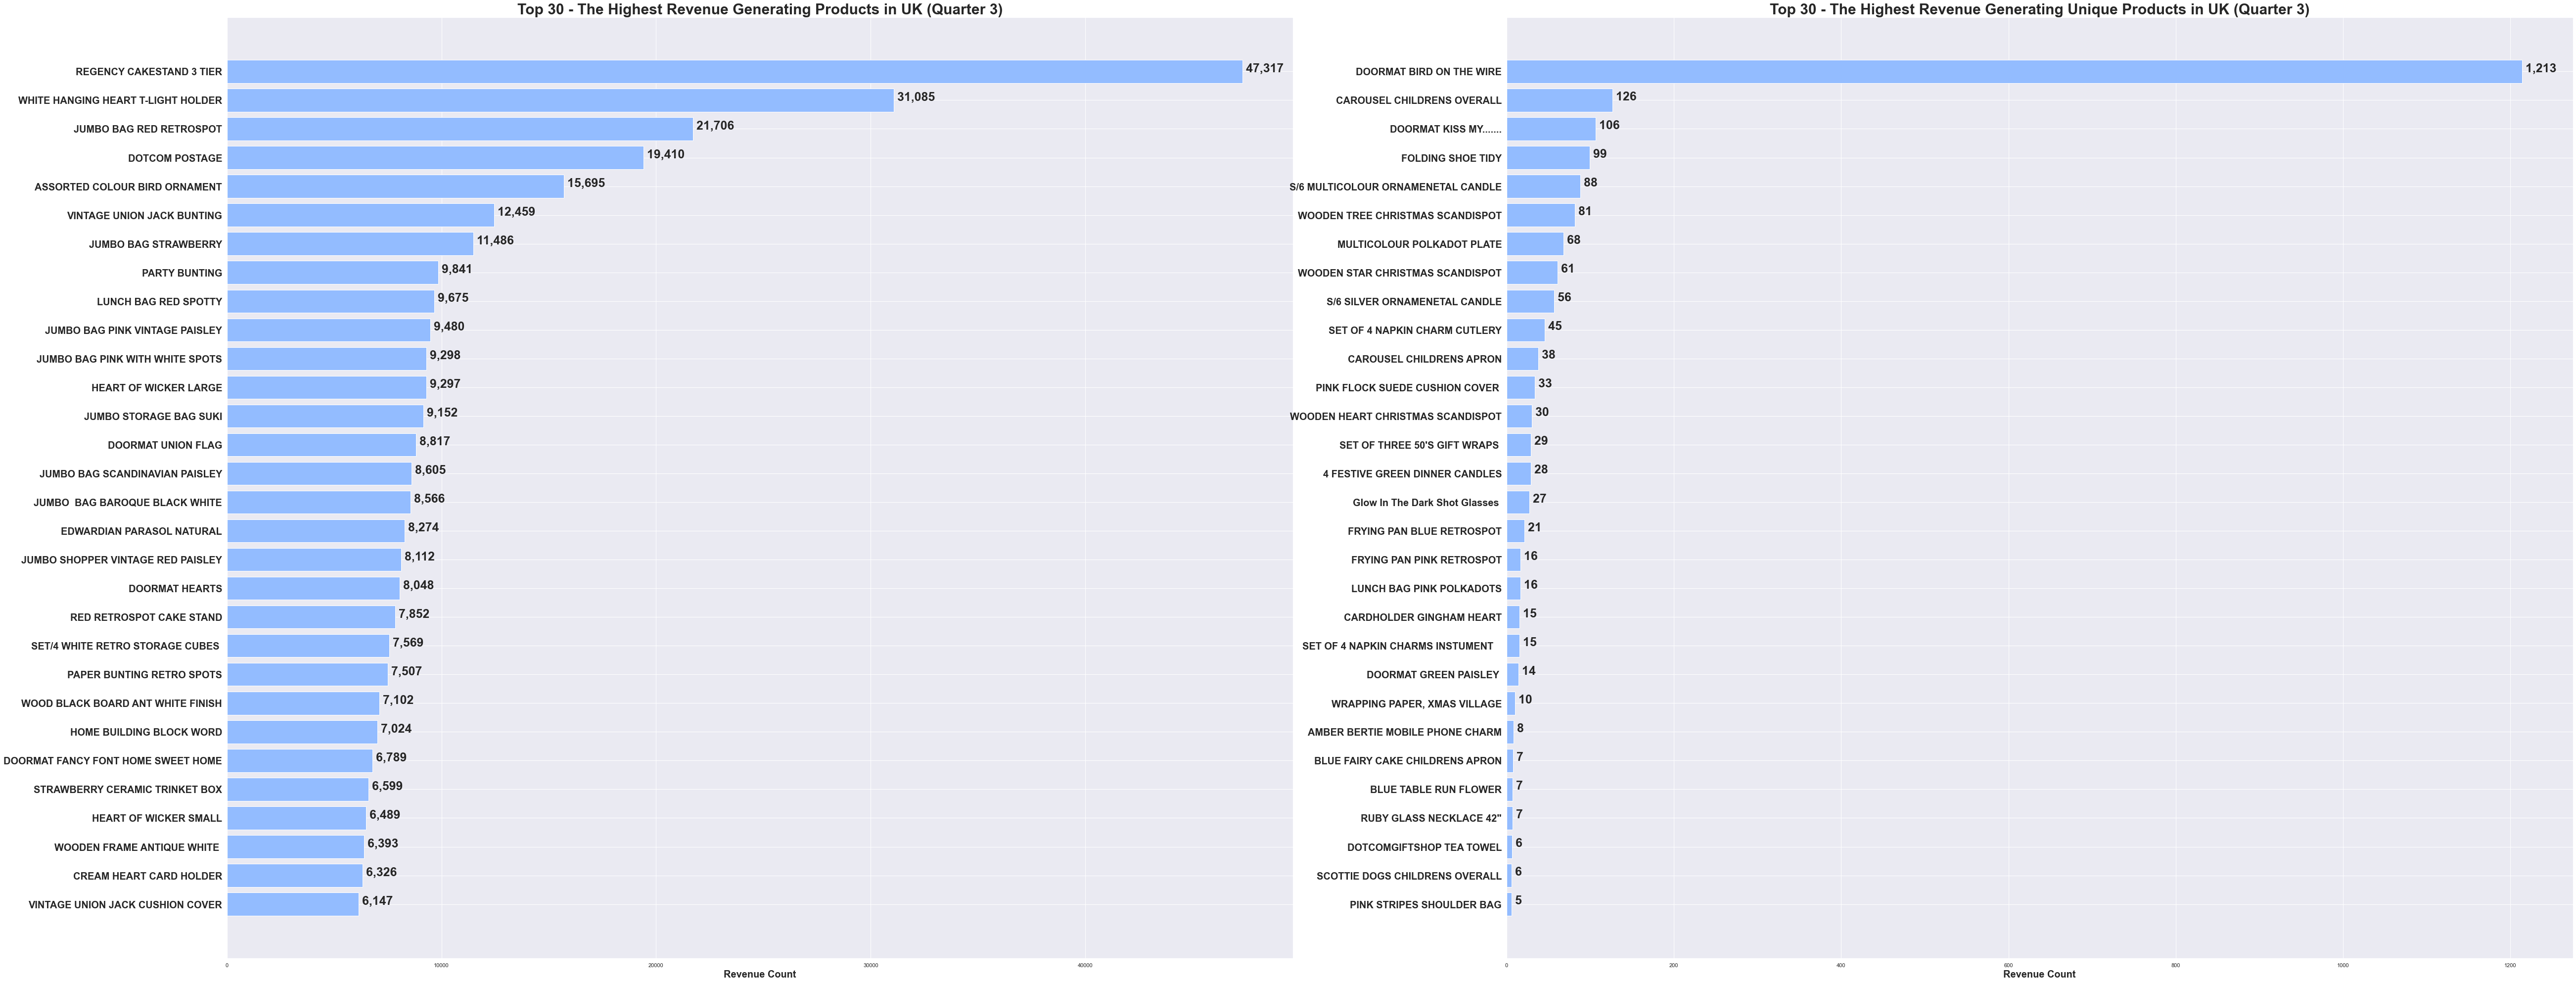

In [70]:
quarter_barh_viz(q3_pro_purchased_quant,q3_uniqprod_purchased_quant, 0, 3)
print('      _____________________________________________________________________________________________________________')
quarter_barh_viz(prod_revenue_q3,uniqprod_revenue_q3, 1, 3)

### Quarter 4

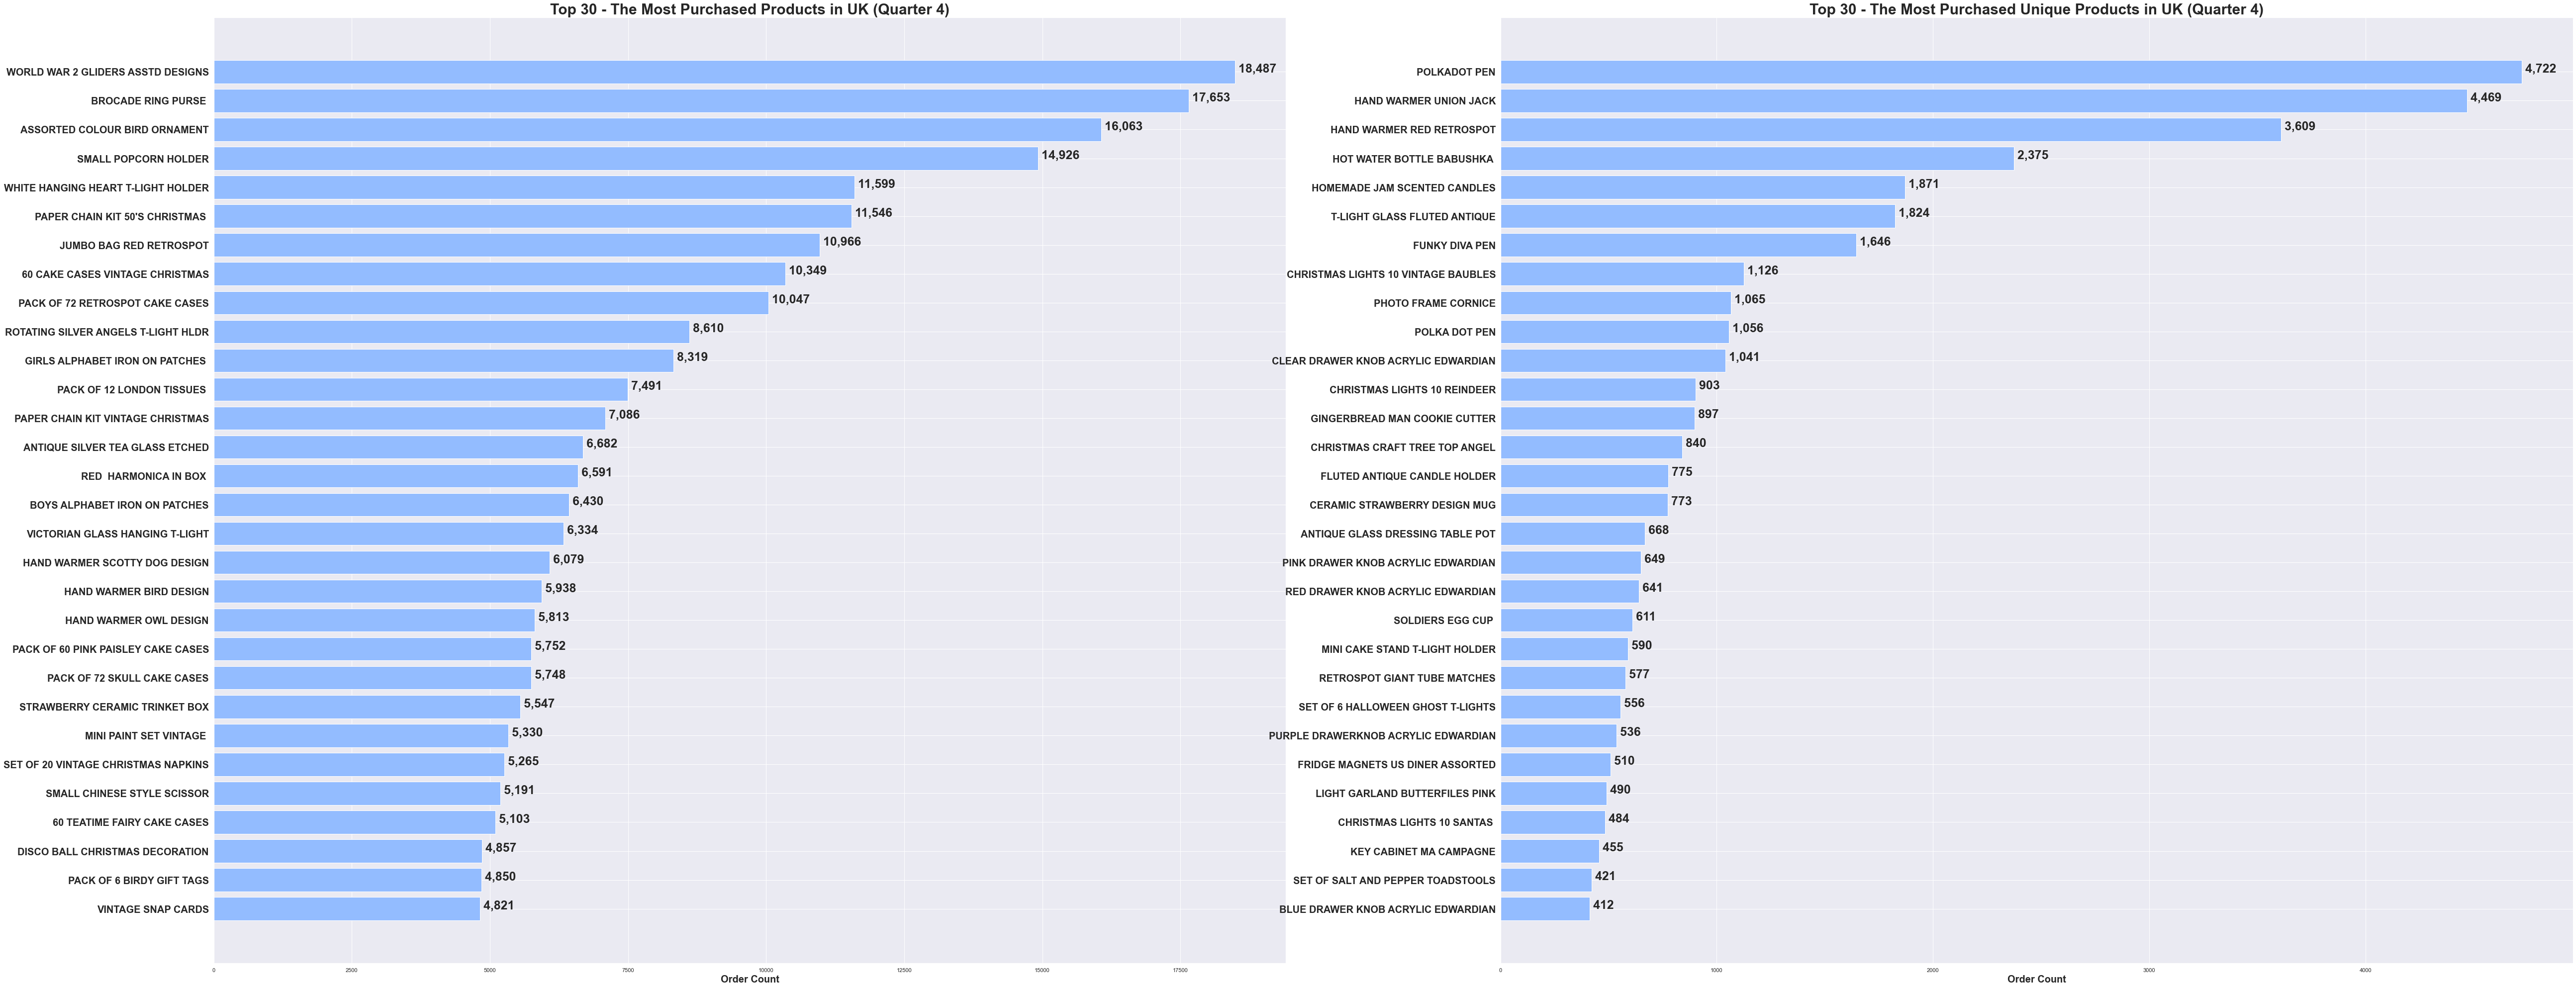

      _____________________________________________________________________________________________________________


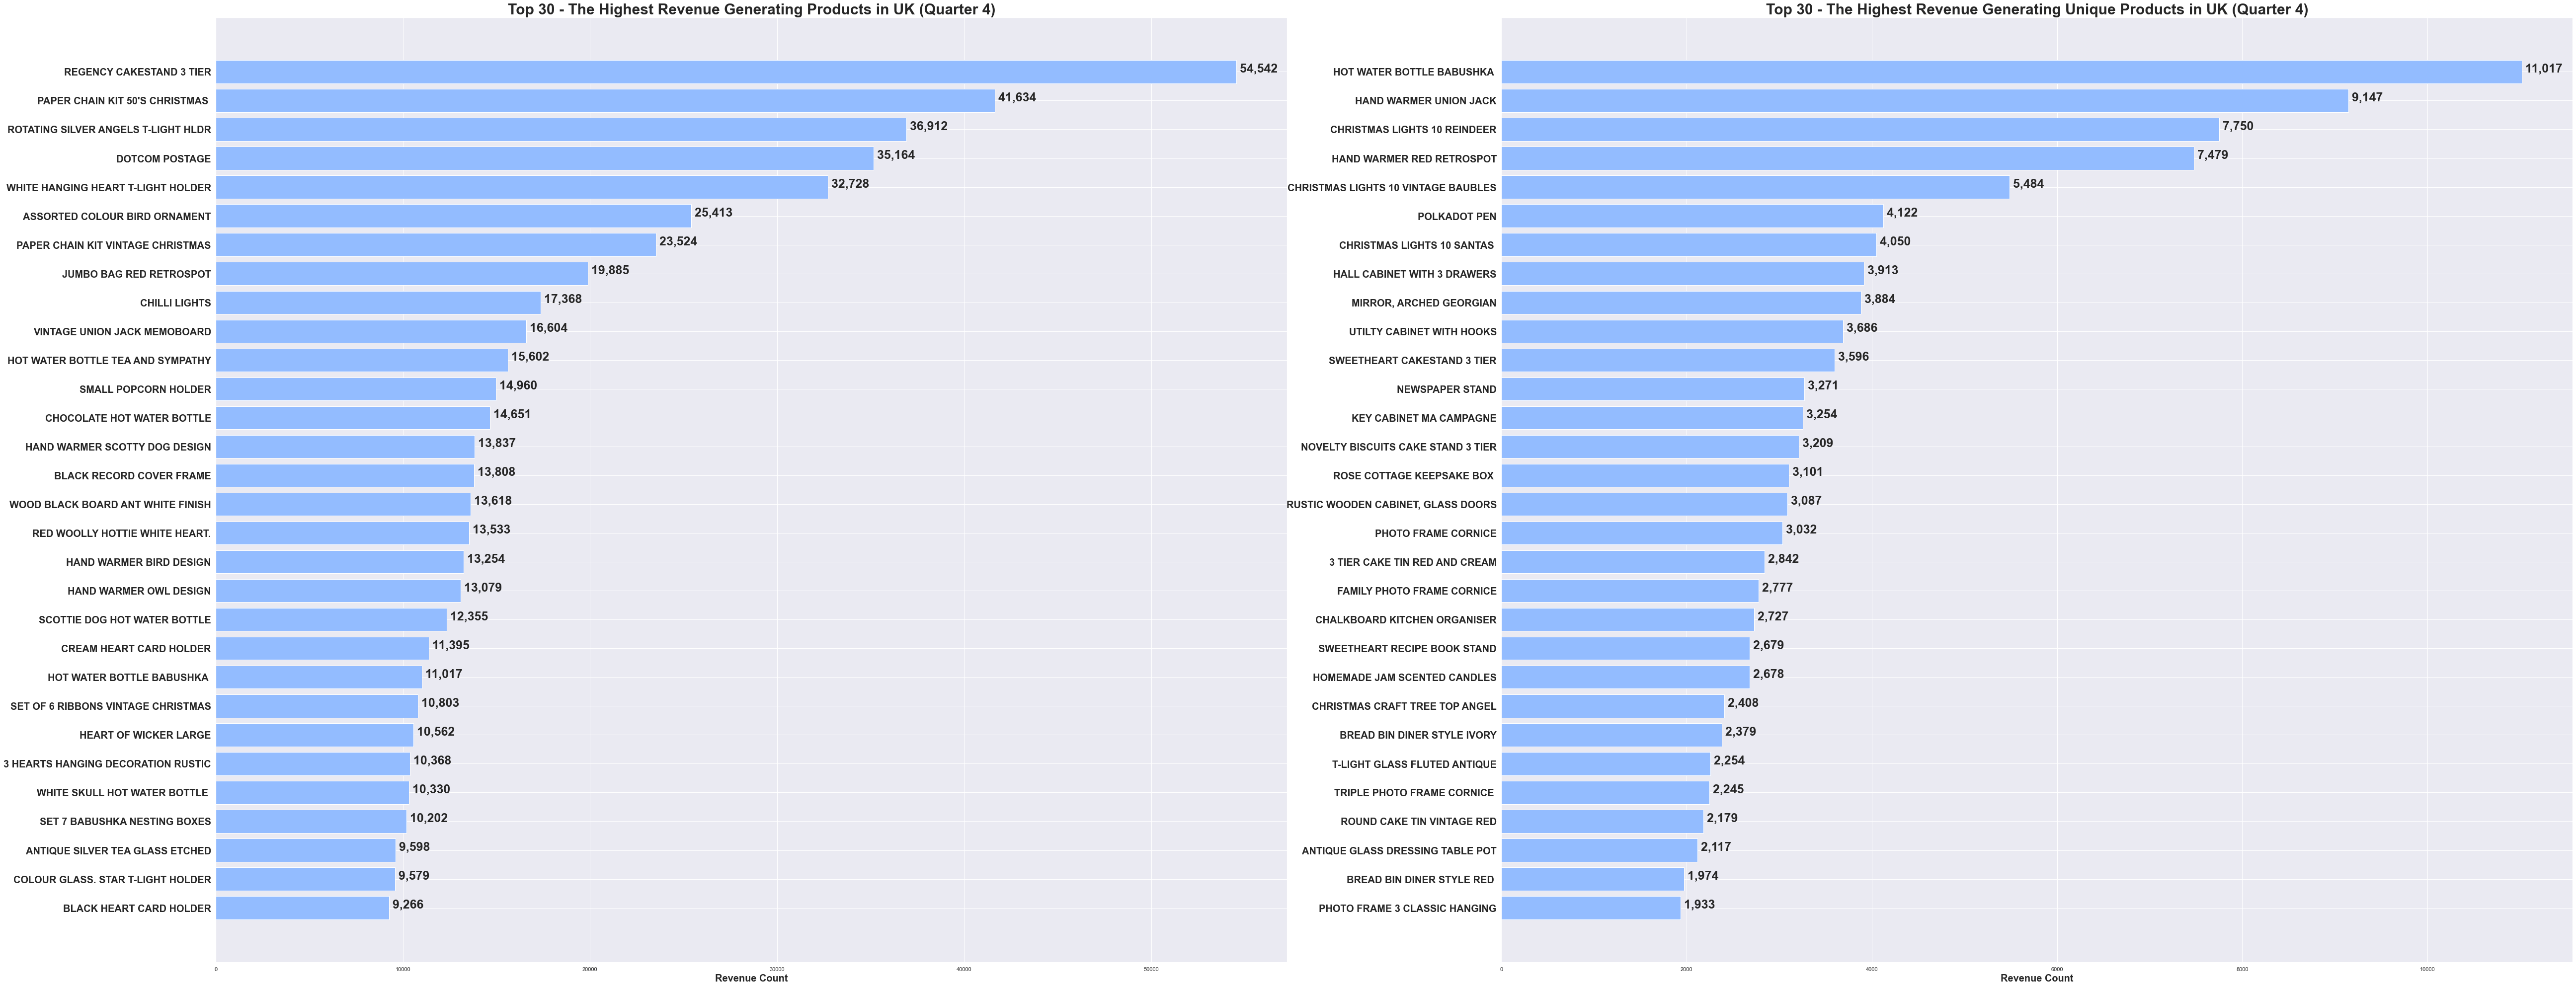

In [71]:
quarter_barh_viz(q4_pro_purchased_quant,q4_uniqprod_purchased_quant, 0, 4)
print('      _____________________________________________________________________________________________________________')
quarter_barh_viz(prod_revenue_q4,uniqprod_revenue_q4, 1, 4)

# Customer Analysis

### New and Existing Customers

In [72]:
uk_customer_df = retail_df[retail_df['Country'] == 'United Kingdom'].copy()

# Dropping the rows with NaN values in the column 'Customer ID' .
uk_customer_df = uk_customer_df[uk_customer_df['Customer ID'].isna() !=  True].reset_index(drop = True)
min_purchase_df = uk_customer_df.loc[:,['Customer ID','YearMonth']].groupby('Customer ID', as_index = False).min()
min_purchase_df.rename(columns={"YearMonth":"MinPurchaseDate"}, inplace= True)
min_purchase_df

Customer ID  MinPurchaseDate
0     12346.00000           200912
1     12608.00000           201010
2     12745.00000           201005
3     12746.00000           200912
4     12747.00000           200912
...           ...              ...
3973  18283.00000           201002
3974  18284.00000           201010
3975  18285.00000           201002
3976  18286.00000           200912
3977  18287.00000           200912

[3978 rows x 2 columns]

In [73]:
# Finding 'New' and 'Existing' customer ratios.
uk_customer_df = pd.merge(uk_customer_df,min_purchase_df, on = 'Customer ID')
uk_customer_df['CustomerType'] = np.where(uk_customer_df['YearMonth'] > uk_customer_df['MinPurchaseDate'], 
                                          'Existing', 
                                          'New')
uk_customer_df

Invoice StockCode                          Description  Quantity  \
0       489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1       489434    79323P                   PINK CHERRY LIGHTS        12   
2       489434    79323W                  WHITE CHERRY LIGHTS        12   
3       489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4       489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   
...        ...       ...                                  ...       ...   
371635  538145     35648             VINTAGE BEAD PINK PURSE         12   
371636  538145     22276        WASH BAG VINTAGE ROSE PAISLEY         6   
371637  538145    82494L          WOODEN FRAME ANTIQUE WHITE          6   
371638  538145     22469                HEART OF WICKER SMALL        12   
371639  538145     21135     VICTORIAN  METAL POSTCARD SPRING         8   

               InvoiceDate   Price  Customer ID         Country  YearMonth  \
0      2009-12-01 07:45:00 6.95000  13085.00000  United Kingdom     200912   
1      2009-12-01 07:45:00 6.75000  13085.00000  United Kingdom     200912   
2      2009-12-01 07:45:00 6.75000  13085.00000  United Kingdom     200912   
3      2009-12-01 07:45:00 2.10000  13085.00000  United Kingdom     200912   
4      2009-12-01 07:45:00 1.25000  13085.00000  United Kingdom     200912   
...                    ...     ...          ...             ...        ...   
371635 2010-12-09 16:08:00 2.95000  15211.00000  United Kingdom     201012   
371636 2010-12-09 16:08:00 2.55000  15211.00000  United Kingdom     201012   
371637 2010-12-09 16:08:00 2.95000  15211.00000  United Kingdom     201012   
371638 2010-12-09 16:08:00 1.65000  15211.00000  United Kingdom     201012   
371639 2010-12-09 16:08:00 1.69000  15211.00000  United Kingdom     201012   

         Revenue  MinPurchaseDate CustomerType  
0       83.40000           200912          New  
1       81.00000           200912          New  
2       81.00000           200912          New  
3      100.80000           200912          New  
4       30.00000           200912          New  
...          ...              ...          ...  
371635  35.40000           201012          New  
371636  15.30000           201012          New  
371637  17.70000           201012          New  
371638  19.80000           201012          New  
371639  13.52000           201012          New  

[371640 rows x 12 columns]

### Monthly Revenue of New and Existing Customers in 2010

In [74]:
uk_customer_df['Revenue'] = uk_customer_df['Quantity'] * uk_customer_df['Price']

In [75]:
customer_ratio = uk_customer_df[['YearMonth','CustomerType','Revenue']].groupby(['YearMonth','CustomerType'], as_index = False).sum()

In [76]:
customer_ratio

YearMonth CustomerType      Revenue
0      200912          New 591658.12000
1      201001     Existing 274481.62100
2      201001          New 124068.35100
3      201002     Existing 264786.57300
4      201002          New 136454.72300
5      201003     Existing 385526.15000
6      201003          New 181019.86100
7      201004     Existing 395197.06100
8      201004          New  95737.93000
9      201005     Existing 380035.31000
10     201005          New  85230.05000
11     201006     Existing 407505.14000
12     201006          New 102435.76000
13     201007     Existing 436040.10000
14     201007          New  51435.77000
15     201008     Existing 439609.60000
16     201008          New  52784.76000
17     201009     Existing 511073.76100
18     201009          New 143046.67000
19     201010     Existing 703586.40000
20     201010          New 146539.36000
21     201011     Existing 827484.19200
22     201011          New 123802.42000
23     201012     Existing 259844.55000
24     201012          New  11317.12000

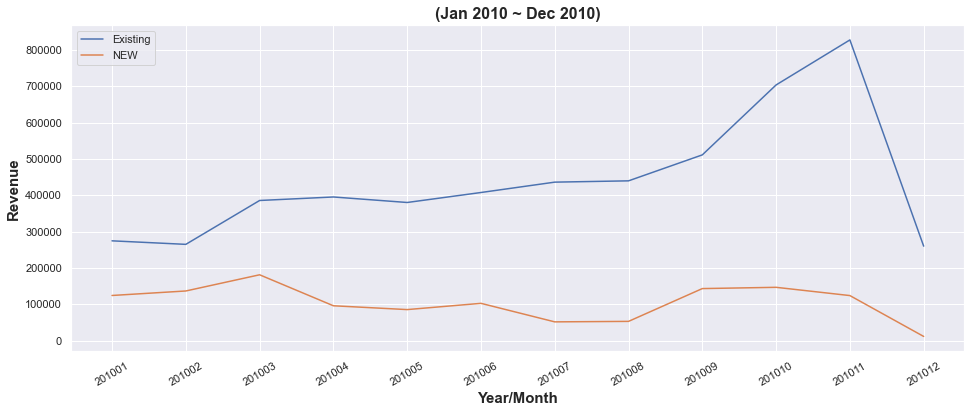

In [77]:
plt.figure(figsize= (16,6))

plt.ticklabel_format(style='plain')
plt.plot(customer_ratio[customer_ratio['CustomerType'] != 'New']['YearMonth'].astype(dtype = str), 
         customer_ratio[customer_ratio['CustomerType'] != 'New']['Revenue'], label = 'Existing')
plt.plot(customer_ratio[customer_ratio['CustomerType'] != 'Existing']['YearMonth'].astype(dtype = str)[1:], 
         customer_ratio[customer_ratio['CustomerType'] != 'Existing']['Revenue'][1:],label = 'NEW')
plt.legend(loc="upper left")
plt.xticks(rotation = 30)
plt.xlabel('Year/Month', size = 15, weight = 'bold')
plt.ylabel('Revenue', size = 15, weight = 'bold')


plt.title('(Jan 2010 ~ Dec 2010)', size = 16, weight = 'bold')


plt.show()

- We can see that the existing customers' trend is increasing while the new customer trend is slightly decreasing.

- Also, in December, both existing and new customers showed a negative trend. As I mentioned before, it may be because the data for December is incomplete, or maybe the website was down, and customers could not access it.

# Segmentation of the United Kingdom Customers

### RFM Analysis
    RFM - is a marketing analysis method used to identify the firm's best clients based on the nature of their spending habits.

### Calculation of R-recency, F-frequency, M-monetary
    - Recency: How recent was the customer's last purchase?
    - Frequency: How often did this customer make a purchase in a given period? 
    - Monetary: How much money did the customer spend in a given period?

---
- For calculating Recency, we need to find out the last purchase date of each customer.
- Also, as the data contains the dates from the year 2010, I will assume today is the next day after the last recorded date of the dataset.<br> For example, the last recorded date is "2010-12-09 20:01:00". Therefore, I will assume that today is "2010-12-10 20:01:00".

In [78]:
# Calculating Recency
last_purchase_date = uk_customer_df[['Customer ID','InvoiceDate']].groupby('Customer ID').max()
today_date = last_purchase_date['InvoiceDate'].max() + timedelta(days = 1)
last_purchase_date['Recency'] = (today_date - last_purchase_date)['InvoiceDate'].dt.days

# Calculating Frequency
last_purchase_date['Frequency'] = uk_customer_df[['Customer ID','InvoiceDate']].groupby('Customer ID').count()


# Calculating Monetary
last_purchase_date['Monetary'] = uk_customer_df[['Customer ID','Revenue']].groupby('Customer ID').sum()


# RFM DF
rfm_df = last_purchase_date.drop('InvoiceDate', axis = 1).reset_index(drop =False)


In [79]:
rfm_df

Customer ID  Recency  Frequency   Monetary
0     12346.00000       67         34  368.36000
1     12608.00000       40         16  415.79000
2     12745.00000      122         22  723.85000
3     12746.00000      163         20  230.85000
4     12747.00000        5        161 4949.08000
...           ...      ...        ...        ...
3973  18283.00000       18        217  619.37000
3974  18284.00000       65         29  436.68000
3975  18285.00000      296         12  427.00000
3976  18286.00000      112         70 1188.43000
3977  18287.00000       18         86 2340.61000

[3978 rows x 4 columns]

### Clustering Customers RFM Data with K-means

### Data Preprocessing

In [80]:
rfm_df.describe()

Customer ID    Recency  Frequency     Monetary
count   3978.00000 3978.00000 3978.00000   3978.00000
mean   15566.28632   90.21242   93.42383   1792.53428
std     1582.01830   97.76786  182.54324   7190.25922
min    12346.00000    1.00000    1.00000  -1663.06000
25%    14203.25000   17.00000   18.00000    288.15750
50%    15589.00000   51.00000   43.00000    643.45500
75%    16945.75000  135.00000  103.00000   1592.48250
max    18287.00000  374.00000 5012.00000 346585.95000

<AxesSubplot:xlabel='Recency', ylabel='Density'>

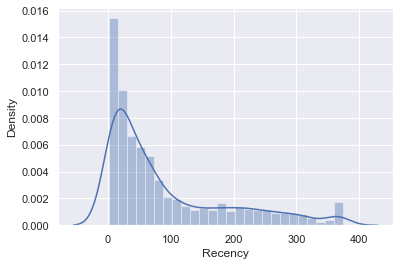

In [81]:
sns.distplot(rfm_df['Recency'])

<AxesSubplot:xlabel='Frequency', ylabel='Density'>

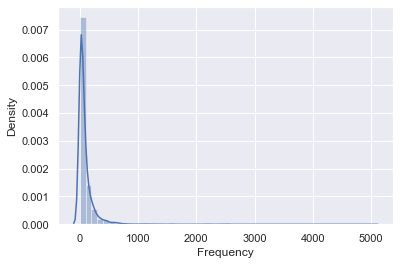

In [82]:
 sns.distplot(rfm_df['Frequency'])

<AxesSubplot:xlabel='Monetary', ylabel='Density'>

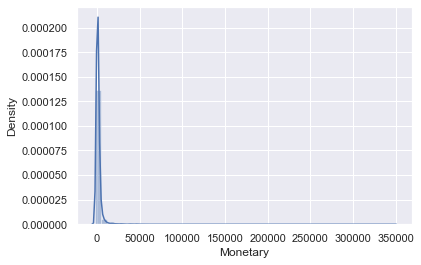

In [83]:
sns.distplot(rfm_df['Monetary'])

In [84]:
rfm_df.describe()

Customer ID    Recency  Frequency     Monetary
count   3978.00000 3978.00000 3978.00000   3978.00000
mean   15566.28632   90.21242   93.42383   1792.53428
std     1582.01830   97.76786  182.54324   7190.25922
min    12346.00000    1.00000    1.00000  -1663.06000
25%    14203.25000   17.00000   18.00000    288.15750
50%    15589.00000   51.00000   43.00000    643.45500
75%    16945.75000  135.00000  103.00000   1592.48250
max    18287.00000  374.00000 5012.00000 346585.95000

- All three Recency, Frequency, and Monetary data are so skewed. Thus, I will apply the logarithm function to them to unskewed the data before using the K-means model. 
<br> Values that are equal to zero or negative become infinite negative when applying logarithm to them. Therefore, I will replace those values with one.

In [85]:
rfm_df['Monetary'] = rfm_df['Monetary'].map(lambda x: 1 if x <= 0 else x)

In [86]:
rfm_df.describe()

Customer ID    Recency  Frequency     Monetary
count   3978.00000 3978.00000 3978.00000   3978.00000
mean   15566.28632   90.21242   93.42383   1793.41934
std     1582.01830   97.76786  182.54324   7189.97941
min    12346.00000    1.00000    1.00000      1.00000
25%    14203.25000   17.00000   18.00000    288.15750
50%    15589.00000   51.00000   43.00000    643.45500
75%    16945.75000  135.00000  103.00000   1592.48250
max    18287.00000  374.00000 5012.00000 346585.95000

In [87]:
log_recency = np.log(rfm_df['Recency'])

In [88]:
log_frequency = np.log(rfm_df['Frequency'])

In [89]:
log_monetary = np.log(rfm_df['Monetary'])

<AxesSubplot:xlabel='Recency', ylabel='Density'>

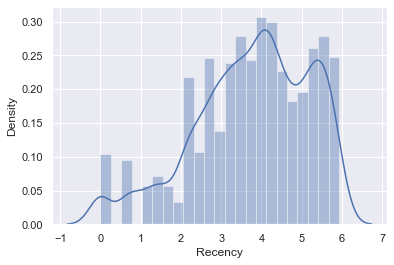

In [90]:
sns.distplot(log_recency)

<AxesSubplot:xlabel='Frequency', ylabel='Density'>

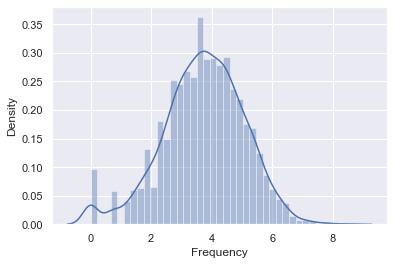

In [91]:
sns.distplot(log_frequency)

<AxesSubplot:xlabel='Monetary', ylabel='Density'>

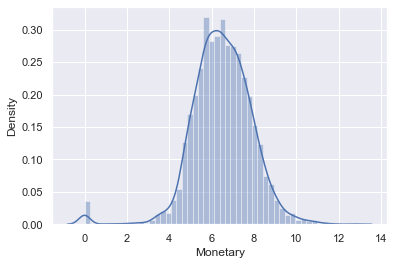

In [92]:
sns.distplot(log_monetary)

### Finding right number of K

In [93]:
def wcss_vis(series):
    wcss = []
    for i in range(2,15):
        kmeans_pca = KMeans(i, random_state = 42)
        kmeans_pca.fit(series.values.reshape(-1,1))
        wcss.append(kmeans_pca.inertia_)
    plt.figure(figsize = (10,8))
    plt.plot(range(2, 15), wcss, marker = 'o', linestyle = '--')
    plt.xlabel('Number of Clusters')
    plt.ylabel('WCSS')
    plt.title('K-means with PCA Clustering')

(None, None, None)

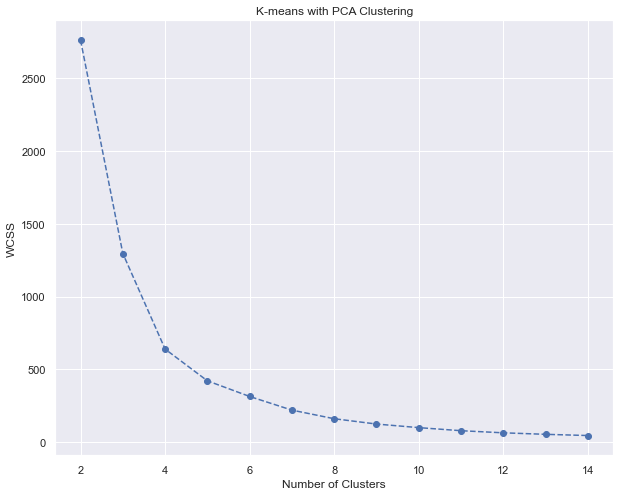

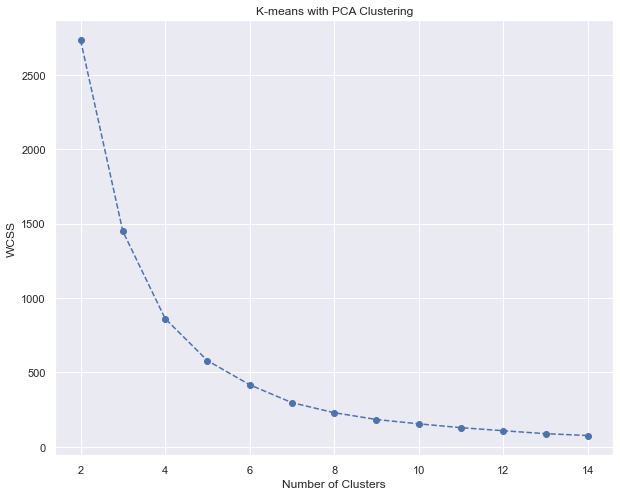

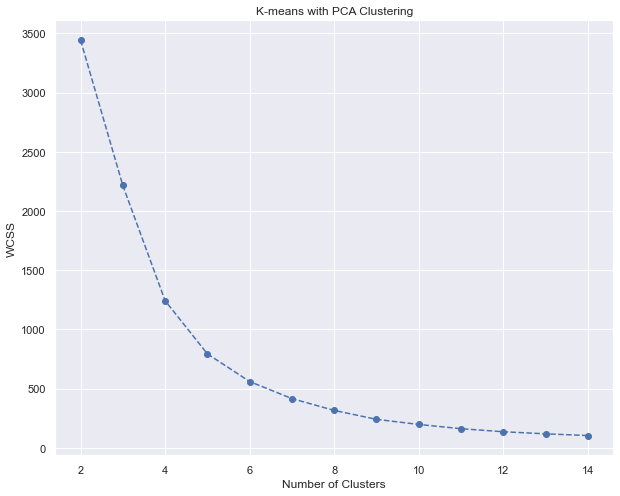

In [94]:
wcss_vis(log_recency), wcss_vis(log_frequency), wcss_vis(log_monetary)

## Clustering of RFM

**Step # 1** - I will cluster Recency, Frequency, and Monetary separately using K-Means. 

**Step # 2** - I will sort the obtained clusters (the ones mentioned in step # 1), so the cluster with the best values(the ones that contain the best customers) has a higher number which I will use for scoring.

**Step # 3** - I will use sorted K-means labels(scores) to calculate the total score of each customer.

In [95]:
def kmeans_cl(n,series):
    kmeans_pca = KMeans(n, random_state = 42)
    kmeans_pca.fit(series.values.reshape(-1,1))
    return kmeans_pca.labels_

In [96]:
rfm_df['Recency_Clusters'] = kmeans_cl(4,log_recency)
rfm_df['Frequency_Clusters'] = kmeans_cl(4,log_frequency)
rfm_df['Monetary_Clusters'] = kmeans_cl(4,log_monetary)

### Sorting Clusters

In [97]:
# Crating a function that will sort clusters.
def sort_clusters(rfm_df,sorting_by,group_by):
    if sorting_by != 'Recency':
        tmp_df = rfm_df[[sorting_by,group_by]].groupby(group_by).mean().sort_values(sorting_by, ascending = True)
    else: 
        tmp_df = rfm_df[[sorting_by,group_by]].groupby(group_by).mean().sort_values(sorting_by, ascending = False)
    cluster_idx = tmp_df.reset_index()[group_by]
    new_indx = cluster_idx.reset_index()['index']
    mapping_dict = dict(zip(cluster_idx,new_indx))
    rfm_df[group_by] = rfm_df[group_by].map(mapping_dict)
    return

## K-Means Results

### Recency

In [98]:
# Recency clusters before sorting
rfm_df[['Recency','Recency_Clusters']].groupby('Recency_Clusters').mean()

Recency
Recency_Clusters          
0                 56.32935
1                  2.68957
2                220.05281
3                 15.69619

In [99]:
# Recency clusters after sorting
sort_clusters(rfm_df, 'Recency','Recency_Clusters')
rfm_df[['Recency','Recency_Clusters']].groupby('Recency_Clusters').mean()

Recency
Recency_Clusters          
0                220.05281
1                 56.32935
2                 15.69619
3                  2.68957

### Frequency

In [100]:
# Frequency clusters before sorting
rfm_df[['Frequency','Frequency_Clusters']].groupby('Frequency_Clusters').mean()

Frequency
Frequency_Clusters           
0                     3.86189
1                    66.34841
2                   295.44683
3                    19.36879

In [101]:
# Frequency clusters after sorting
sort_clusters(rfm_df, 'Frequency','Frequency_Clusters')
rfm_df[['Frequency','Frequency_Clusters']].groupby('Frequency_Clusters').mean()

Frequency
Frequency_Clusters           
0                     3.86189
1                    19.36879
2                    66.34841
3                   295.44683

### Monetary

In [102]:
# Monetary Clusters before sorting
rfm_df[['Monetary','Monetary_Clusters']].groupby('Monetary_Clusters').mean()

Monetary
Monetary_Clusters           
0                  217.60961
1                 5978.10541
2                  898.14044
3                    2.87404

In [103]:
# Monetary Clusters after sorting
sort_clusters(rfm_df, 'Monetary','Monetary_Clusters')
rfm_df[['Monetary','Monetary_Clusters']].groupby('Monetary_Clusters').mean()

Monetary
Monetary_Clusters           
0                    2.87404
1                  217.60961
2                  898.14044
3                 5978.10541

### Calculating Overall Score

In [104]:
rfm_df['FinalScore'] = rfm_df['Recency_Clusters'] + rfm_df['Frequency_Clusters'] + rfm_df['Monetary_Clusters']

In [105]:
rfm_df[['Recency', 'Frequency', 'Monetary','FinalScore']].groupby('FinalScore').mean()

Recency  Frequency   Monetary
FinalScore                                
0          287.51613    1.74194    3.38806
1          233.40217    4.15761  126.35158
2          204.93858   14.19002  225.92595
3          127.39201   23.74229  342.32711
4           94.99055   36.52598  700.27321
5           56.78774   62.49214 1042.93368
6           36.78125  101.85742 1631.89387
7           25.26942  170.53155 2752.81892
8           11.99692  268.41231 6257.36232
9            2.70175  454.75439 9901.90439

- The table above shows the average values of Recency, Frequency, and Monetary. 
<br>Through this table, we can infer that customers who obtained a score of 9 are those who often make purchases, spend a good amount of money, and have recently made a purchase, compared to customers with lower scores (score 0, 1, 2).

### Creating Easily Readable Labels to Differentiate Customers.

In [106]:
mapping_dict = {9:'Best_Customers', 8:'Loyal_Customers',7:'Potential_Loyalists', 6:'Potential_Loyalists', 5:'Promising_Customers',
4:'Hibernating',3:'Hibernating', 2:'Lost_Customers', 1:'Lost_Customers',0:'Lost_Customers'}

In [107]:
rfm_df['Labels'] = rfm_df['FinalScore'].map(mapping_dict)

In [108]:
rfm_summary = rfm_df[['Recency', 'Frequency', 'Monetary','FinalScore','Labels']].groupby(['FinalScore','Labels']).mean()
rfm_summary

Recency  Frequency   Monetary
FinalScore Labels                                             
0          Lost_Customers      287.51613    1.74194    3.38806
1          Lost_Customers      233.40217    4.15761  126.35158
2          Lost_Customers      204.93858   14.19002  225.92595
3          Hibernating         127.39201   23.74229  342.32711
4          Hibernating          94.99055   36.52598  700.27321
5          Promising_Customers  56.78774   62.49214 1042.93368
6          Potential_Loyalists  36.78125  101.85742 1631.89387
7          Potential_Loyalists  25.26942  170.53155 2752.81892
8          Loyal_Customers      11.99692  268.41231 6257.36232
9          Best_Customers        2.70175  454.75439 9901.90439

In [109]:
rfm_summary['N_Customer'] = rfm_df[['Recency','FinalScore','Labels']].groupby(['FinalScore','Labels']).count()
rfm_summary['Prop%'] = np.round(((rfm_summary['N_Customer'] / rfm_summary['N_Customer'].sum()) * 100),2)
pd.options.display.float_format = "{:,.2f}".format

In [110]:
rfm_summary

Recency  Frequency  Monetary  N_Customer  \
FinalScore Labels                                                          
0          Lost_Customers        287.52       1.74      3.39          31   
1          Lost_Customers        233.40       4.16    126.35         184   
2          Lost_Customers        204.94      14.19    225.93         521   
3          Hibernating           127.39      23.74    342.33         551   
4          Hibernating            94.99      36.53    700.27         635   
5          Promising_Customers    56.79      62.49  1,042.93         636   
6          Potential_Loyalists    36.78     101.86  1,631.89         512   
7          Potential_Loyalists    25.27     170.53  2,752.82         412   
8          Loyal_Customers        12.00     268.41  6,257.36         325   
9          Best_Customers          2.70     454.75  9,901.90         171   

                                Prop%  
FinalScore Labels                      
0          Lost_Customers        0.78  
1          Lost_Customers        4.63  
2          Lost_Customers       13.10  
3          Hibernating          13.85  
4          Hibernating          15.96  
5          Promising_Customers  15.99  
6          Potential_Loyalists  12.87  
7          Potential_Loyalists  10.36  
8          Loyal_Customers       8.17  
9          Best_Customers        4.30

The table above shows that after labeling, it is easier to differentiate the types of customers we have:
 - Most loyal and best customers.
 - Customers that need our attention; otherwise, we could lose them.
 - Customers that could become more loyal.
 
For example:
- For the 'Potential_loyalists' segments, the company could increase their loyalty by following loyalty programs such as discount vouchers, loyalty cards, and raffles.
- Also, by analyzing the best customers, the company could gather data and then find new customers with similar ages, incomes, interests, etc.

To conclude, K-means clustering of RFM data is a great way to learn more about customers' behavior, and it can help create an effective marketing strategy to boost our business.